In [1]:
import ROOT as R
import ctypes
import math

# R.gStyle.SetOptStat(0)
# %jsroot on

Welcome to JupyROOT 6.24/06


In [2]:
def PhaseFit(wiggle,fitModel,t_start,t_end):
    wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    phi = fitModel.GetParameter(3)
    if phi < - math.pi/2:    
        fitModel.SetParameter(3,phi+math.pi)
        fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
        wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    elif phi > math.pi/2: 
        fitModel.SetParameter(3,phi-math.pi)
        fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
        wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    


def FitScan_energySlices(bin_limit,hist_2d,fitModel):
    energy_low = int((bin_limit[0]-1) * e_bin_width)
    energy_high = int(bin_limit[1] * e_bin_width)
    slice_name = 'Slice_%s_%s_MeV'%(energy_low,energy_high)
    wiggle = hist_2d.ProjectionX(slice_name,bin_limit[0],bin_limit[1])
    fitModel.SetNpx(1000)
    wiggle.SetTitle('{0:}; time [#mu s]; N / {1} #mu s'.format(slice_name, t_bin_width))
    PhaseFit(wiggle,fitModel,t_start,t_end)
    # wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    # phi = fitModel.GetParameter(3)
    # if phi < - math.pi/2:    
    #     fitModel.SetParameter(3,phi+math.pi)
    #     fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
    #     wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    # elif phi > math.pi/2: 
    #     fitModel.SetParameter(3,phi-math.pi)
    #     fitModel.SetParameter(2,0.-fitModel.GetParameter(2))
    #     wiggle.Fit(fitModel,'EMQ','',t_start,t_end)
    return wiggle

In [3]:
#predefine variables
cyclotron = 0.149 # micro-second
gamma = 29.3
omega_a_ref =  2 * math.pi / (gamma * cyclotron)
e_thresh = 1650
print omega_a_ref

1.43921600366


In [4]:
tfile = R.TFile('../Data/ETout.root')

In [5]:
#collect histos
th2_all = tfile.Get('all')
th2_calos = []
for n in range(24):
    th2_calo = tfile.Get('ET%s'%(n+1))
    th2_calos.append(th2_calo)

## Validation of input file

* 14 billion events in total
* Time start at 29.1 $\mu s$
* Second peak about 350 MeV of energy distribution

this Bin 195 29.094
14410021700.0


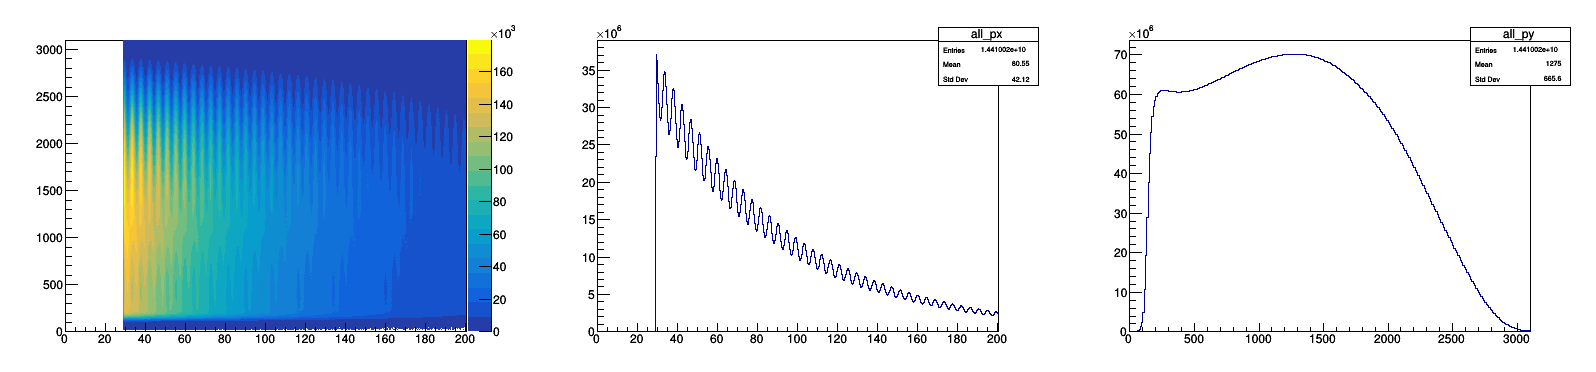

In [6]:
#get binning info
time_dist_all = th2_all.ProjectionX()
t_nbins = time_dist_all.GetNbinsX()
t_bin_width = time_dist_all.GetBinWidth(1)
t_start = -1.
t_end = time_dist_all.GetBinLowEdge(t_nbins+1) + t_bin_width 
for n in range(t_nbins):
    N = time_dist_all.GetBinContent(n+1)
    if N > 100:

        t_start = time_dist_all.GetBinLowEdge(n+1)        
        print 'this Bin',n+1,t_start+t_bin_width
        break

t_start += t_bin_width
e_dist_all = th2_all.ProjectionY()
e_bin_width = e_dist_all.GetBinWidth(1)
e_nbins = e_dist_all.GetNbinsX()
for n in range(e_nbins):
    N = e_dist_all.GetBinContent(n+1)
    if N > 100:
        e_start = e_dist_all.GetBinLowEdge(n+1)
        break
print time_dist_all.Integral()
# print 'time start at       {0:.1f} micro-second'.format(t_start)
# print 'energy start at       {0:.1f} MeV'.format(e_start)
# print 'time end at         %s micro-second'%(t_end)
# print 'time bin width      %s micro-second'%(t_bin_width)
# print 'energy bin width    %s MeV'%(e_bin_width)

#draw hists
#energy start at 20 MeV
canvas = R.TCanvas('c1','c1',1600,400)
canvas.Divide(3)
canvas.cd(1)
th2_all.GetXaxis().SetRangeUser(0,200)
th2_all.GetYaxis().SetRangeUser(0,3100)
th2_all.Draw("COLZ")
canvas.cd(2)
time_dist_all.GetXaxis().SetRangeUser(0,200)
time_dist_all.Draw()
canvas.cd(3)
# e_dist_all.GetYaxis().SetRangeUser(0,80e6)
e_dist_all.GetXaxis().SetRangeUser(0,3100)
e_dist_all.Draw()
canvas.Draw()

In [7]:
#names convention
names = ['N','tau','Ac','As','R']
namesPhase = ['N','tau','A','phi','R']

#build fit phase-fit model 
five_param_phase_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[5]*(1+[4]*1e-6)-[3]))'
phase_fit = R.TF1('phasefit', five_param_phase_str, t_start, t_end)
phase_fit.SetParNames('N', '#tau', 'A', '#phi', 'R', '#omega_{a} ref')
phase_fit.SetParameters(5e+7, 66.38, 0.2, 0, 116., omega_a_ref)
phase_fit.FixParameter(5, omega_a_ref)
phase_fit.SetParLimits(3, -math.pi/2-0.1, math.pi/2+0.1)
phase_fit.SetNpx(1000)

#build fit A_s*sin+A_c*cos model
five_param_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[5]*(1+[4]*1e-6))+[3]*sin(x*[5]*(1+[4]*1e-6)))'
cos_sin_fit = R.TF1('cos_sin_fit', five_param_str, t_start, t_end)
cos_sin_fit.SetParNames('N', '#tau', 'A_{c}', 'A_{s}', 'R', '#omega_{a} ref')
cos_sin_fit.SetParameters(5e+7, 66.38, 0.2, 0, 116., omega_a_ref)
cos_sin_fit.FixParameter(5, omega_a_ref)
cos_sin_fit.SetNpx(1000)

#build fit phase-fit w_a model 
five_param_phase_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[4]-[3]))'
phase_wa_fit = R.TF1('phasefit', five_param_phase_str, t_start, t_end)
phase_wa_fit.SetParNames('N', '#tau', 'A', '#phi', '#omega_{a}')
phase_wa_fit.SetParameters(5e+7, 66.38, 0.2, 0, omega_a_ref)
phase_wa_fit.SetParLimits(3, -math.pi/2-0.1, math.pi/2+0.1)
phase_wa_fit.SetNpx(1000)

#build fit A_s*sin+A_c*cos w_a model
five_param_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[4])+[3]*sin(x*[4]))'
cos_sin_wa_fit = R.TF1('cos_sin_fit', five_param_str, t_start, t_end)
cos_sin_wa_fit.SetParNames('N', '#tau', 'A_{c}', 'A_{s}', '#omega_{a}')
cos_sin_wa_fit.SetParameters(5e+7, 66.38, 0.2, 0, omega_a_ref)
cos_sin_wa_fit.SetNpx(1000)



## Try 5-parameter fitting with wiggle plot

### Two fitting models
* $N_0 \cdot \exp(-t/\tau) \cdot \left[1 + A \cos(\omega_a t + \phi)\right]$
* $N_0 \cdot \exp(-t/\tau) \cdot \left[1 + A_c \cos(\omega_a t) + A_s\sin(\omega_a t)\right]$

Here $\omega_a$ will be parameterized as $\omega_{a,ref} (1 + \textrm{R}*10^{-6})$, with R in ppm.

### Two equivalent fitting models yield the compatible fitting results

In [10]:
five_param_str = '[0]*exp(-x/[1])*(1+[2]*cos(x*[5]*(1+[4]*1e-6))+[3]*sin(x*[5]*(1+[4]*1e-6)))'

In [27]:
#full parameters fit
R.gROOT.LoadMacro('/Users/cheng/workspace/Gm2_Fitter/submitLM/full_para_func.cxx')

SegmentationViolation: int TROOT::LoadMacro(const char* filename, int* error = 0, bool check = kFALSE) =>
    SegmentationViolation: segfault in C++; program state was reset

[/Applications/root_v6.24.00/lib/libCore.6.24.00.so] TUnixSystem::DispatchSignals(ESignals) (no debug info)
[/usr/lib/system/libsystem_platform.dylib] _sigtramp (no debug info)
[<unknown binary>] (no debug info)
[/Applications/root_v6.24.00/lib/libCling.6.24.00.so] (anonymous namespace)::CXXNameMangler::mangleUnqualifiedName(clang::NamedDecl const*, clang::DeclarationName, unsigned int, llvm::SmallVector<llvm::StringRef, 4u> const*) (no debug info)
[/Applications/root_v6.24.00/lib/libCling.6.24.00.so] (anonymous namespace)::CXXNameMangler::mangleLocalName(clang::Decl const*, llvm::SmallVector<llvm::StringRef, 4u> const*) (no debug info)
[/Applications/root_v6.24.00/lib/libCling.6.24.00.so] (anonymous namespace)::CXXNameMangler::mangleName(clang::NamedDecl const*) (no debug info)
[/Applications/root_v6.24.00/lib/libCling.6.24.00.so] (anonymous namespace)::ItaniumMangleContextImpl::mangleCXXName(clang::NamedDecl const*, llvm::raw_ostream&) (no debug info)
[/Applications/root_v6.24.00/lib

 *** Break *** segmentation violation


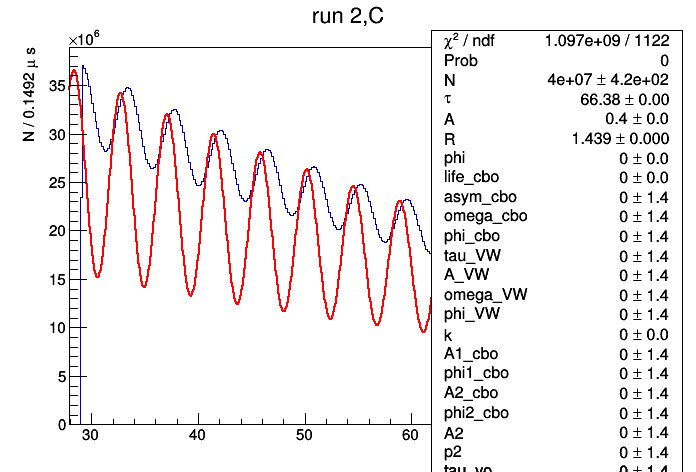

In [26]:
c=R.TCanvas()
wiggle_hist = th2_all.ProjectionX()
fitFunc = R.TF1('full_para',R.blinded_wiggle_fit,0,600,24)
R.gStyle.SetOptFit(1111)
R.gStyle.SetOptStat(0)
fitFunc.SetNpx(1000)
fitFunc.SetParName(0, "N")
fitFunc.SetParName(1, "#tau")
fitFunc.SetParName(2, "A")
fitFunc.SetParName(3, "R")
fitFunc.SetParName(4, "phi")
fitFunc.SetParName(5, "life_cbo")
fitFunc.SetParName(6, "asym_cbo")
fitFunc.SetParName(7, "omega_cbo")
fitFunc.SetParName(8, "phi_cbo")
fitFunc.SetParName(9, "tau_VW")
fitFunc.SetParName(10, "A_VW")
fitFunc.SetParName(11, "omega_VW")
fitFunc.SetParName(12, "phi_VW")
fitFunc.SetParName(13, "k")
fitFunc.SetParName(14, "A1_cbo")
fitFunc.SetParName(15, "phi1_cbo")
fitFunc.SetParName(16, "A2_cbo")
fitFunc.SetParName(17, "phi2_cbo")
fitFunc.SetParName(18, "A2")
fitFunc.SetParName(19, "p2")
fitFunc.SetParName(20, "tau_vo")
fitFunc.SetParName(21, "A_vo")
fitFunc.SetParName(22, "omega_vo")
fitFunc.SetParName(23, "phi_vo")

fitFunc.SetLineColor(R.kRed)
fitFunc.SetParameters(4e+7, 66.38, 0.4, omega_a_ref,0  )
# fitFunc.FixParameter(5, omega_a_ref)
wiggle_hist.Fit(fitFunc, "EMQ",'',20,200)
wiggle_hist.SetTitle('run 2,C; time [#mu s]; N / {0} #mu s'.format(t_bin_width))
wiggle_hist.GetYaxis().SetTitleOffset(1)
R.gPad.SetLogy(0)
wiggle_hist.GetXaxis().SetRangeUser(28,80)
wiggle_hist.GetXaxis().SetRangeUser(28,80)
wiggle_hist.SetStats(0)
wiggle_hist.SetStats(1)
c.Draw()

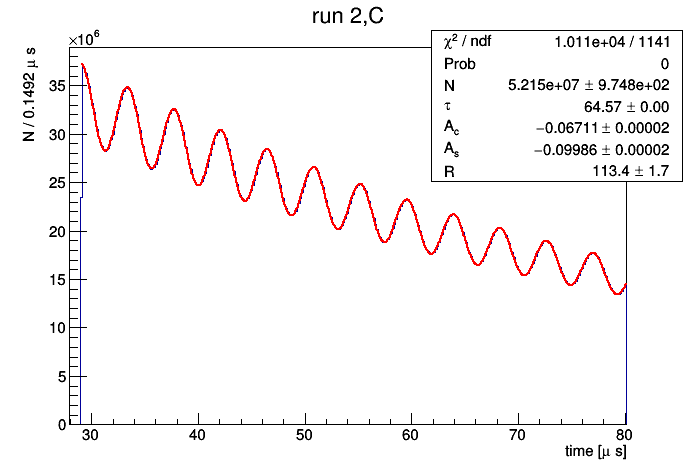

In [45]:
#fit wiggle plot
c = R.TCanvas()
wiggle_hist = th2_all.ProjectionX()
fitFunc = R.TF1('fitFunc',five_param_str,t_start, t_end)
R.gStyle.SetOptFit(1111)
R.gStyle.SetOptStat(0)
fitFunc.SetNpx(1000)
fitFunc.SetParName(0, "N")
fitFunc.SetParName(1, "#tau")
fitFunc.SetParName(2, "A_{c}")
fitFunc.SetParName(3, "A_{s}")
fitFunc.SetParName(4, "R")
fitFunc.SetLineColor(R.kRed)
fitFunc.SetParameters(35e+6, 66.38, 0.4, 0.0, 433, omega_a_ref)
fitFunc.FixParameter(5, omega_a_ref)
wiggle_hist.Fit(fitFunc, "EMQ",'',t_start,t_end)
wiggle_hist.SetTitle('run 2,C; time [#mu s]; N / {0} #mu s'.format(t_bin_width))
wiggle_hist.GetYaxis().SetTitleOffset(1)
R.gPad.SetLogy(0)
wiggle_hist.GetXaxis().SetRangeUser(28,80)
wiggle_hist.GetXaxis().SetRangeUser(28,80)
wiggle_hist.SetStats(0)
wiggle_hist.SetStats(1)
c.Draw()

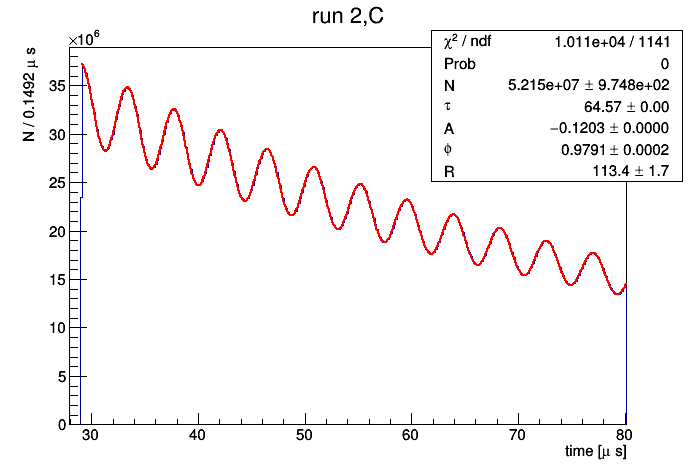

In [48]:
#phase fit overall
R.gStyle.SetOptFit(1111)
canvas = R.TCanvas()
wiggle = th2_all.ProjectionX()
PhaseFit(wiggle,phase_fit,t_start,t_end)
wiggle.GetXaxis().SetRangeUser(t_start,200)
wiggle.SetTitle('run 2,C; time [#mu s]; N / {0} #mu s'.format(t_bin_width))
R.gPad.SetLogy(0)
# wiggle.SetStats(1)
wiggle.GetXaxis().SetRangeUser(28,80)
wiggle.GetXaxis().SetRangeUser(28,80)
wiggle.Draw()
canvas.Draw()

In [17]:
#start time scan
parameter_graphs = [R.TGraphErrors() for n in range(5)]
upper_bound_graphs = [R.TGraph() for n in range(5)]
lower_bound_graphs = [R.TGraph() for n in range(5)]
start_values = []
start_errors = []
for m in range(5):
        parameter_graphs[m].SetTitle(';start time [#mu s];{0}'.format(fitFunc.GetParName(m)))
        upper_bound_graphs[m].SetLineStyle(2)
        lower_bound_graphs[m].SetLineStyle(2)        
#scan 300*0.1492 [#mu s]
start_values = []
start_errors = []
for n in range(0,300):
    this_start = t_start + (n+1) * t_bin_width
    wiggle_hist.Fit(fitFunc,'EMQ','',this_start,t_end)
    for m in range(5):
        value = fitFunc.GetParameter(m)
        error = fitFunc.GetParError(m)
        if n == 0:
            start_values.append(value)
            start_errors.append(error)
        parameter_graphs[m].SetPoint(n,this_start,value)
        parameter_graphs[m].SetPointError(n,0.,error)
        variance_drift = fitFunc.GetParError(m)**2 - start_errors[m]**2
        error_drift = 0. if variance_drift < 0. else variance_drift**0.5
        lower_bound_graphs[m].SetPoint(n,this_start,start_values[m] - error_drift)
        upper_bound_graphs[m].SetPoint(n,this_start,start_values[m] + error_drift)

In [18]:
#dump start time scan results
tfile_out = R.TFile('omegaA_output.root','recreate')
tfile_out.cd()
for n in range(5):
    name_temp = 'starttime_%s_%s'
    parameter_graphs[n].SetName(name_temp%(names[n],'graph'))
    upper_bound_graphs[n].SetName(name_temp%(names[n],'upper'))
    lower_bound_graphs[n].SetName(name_temp%(names[n],'lower'))
    parameter_graphs[n].Write()
    upper_bound_graphs[n].Write()
    lower_bound_graphs[n].Write()

## The start time scan
* Central value of five parameters *vs* start time
* Increasing uncertatinties

## Conculsion
* Best choice of start time: 29.3 $\mu s$
* Shifts of central values are covered by uncertainties except for *N* and $\tau$
* Anticorrelation of *N* and $\tau$

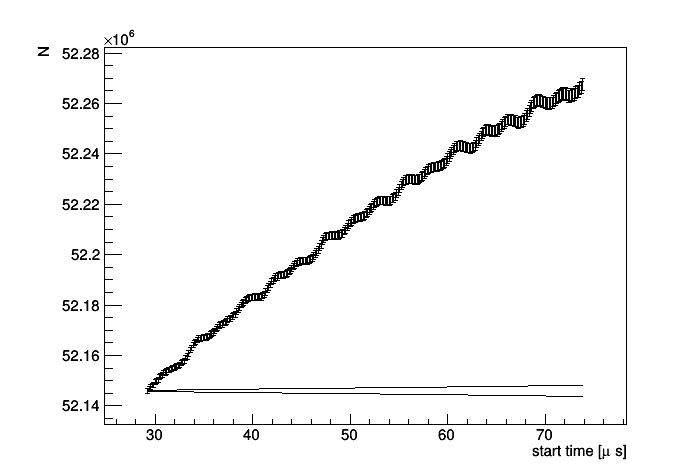

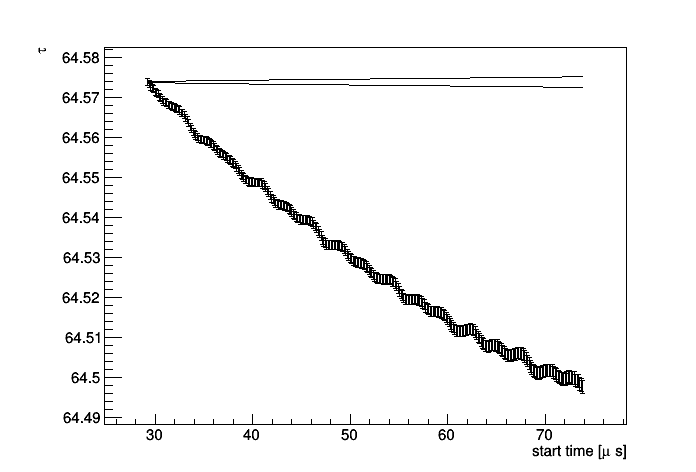

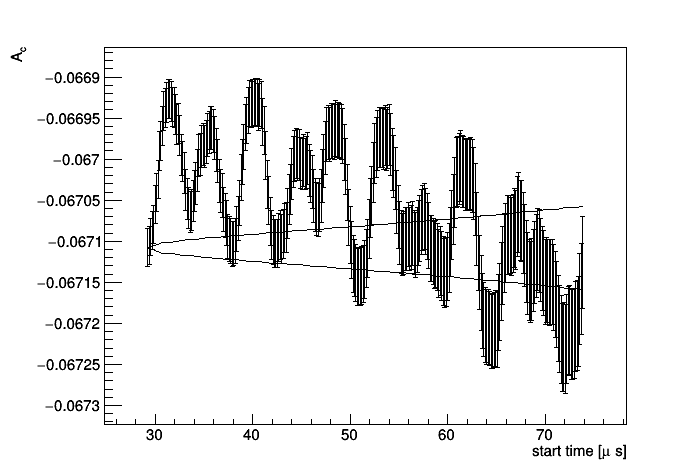

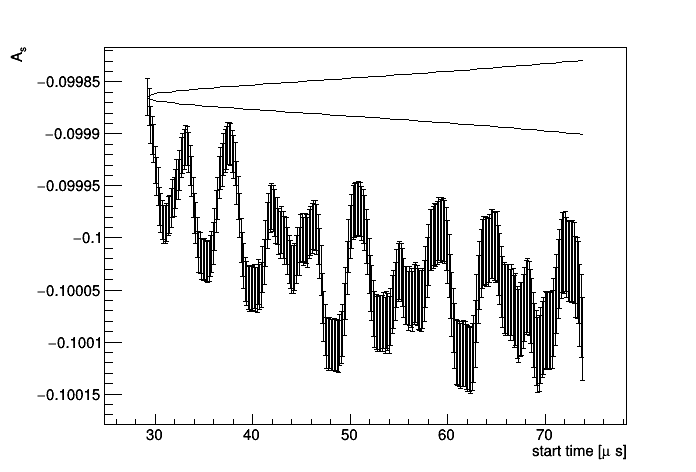

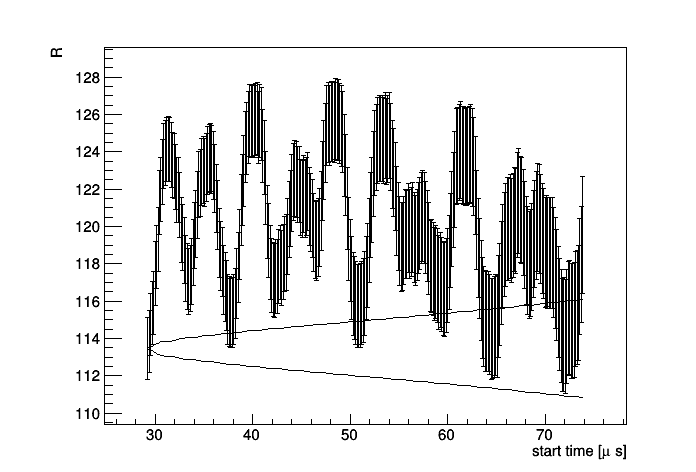

In [19]:
#draw start time scan
canvases = []
for i in range(5):
    canvases.append(R.TCanvas())
    canvases[i].SetLeftMargin(0.15)
    parameter_graphs[i].GetXaxis().SetTitleOffset(0)
    parameter_graphs[i].Draw("ap")
    upper_bound_graphs[i].Draw("l same")
    lower_bound_graphs[i].Draw("l same")
    canvases[i].Draw()

In [20]:
#energy threshold scan
central_graphs = [R.TGraphErrors() for n in range(5)]
error_graphs = [R.TGraph() for n in range(5)]
name_temp = 'energythreshold_%s_%s'
#setup graphs
for n in range(5):
    central_graphs[n].SetName(name_temp%(names[n],'graph'))
    error_graphs[n].SetName(name_temp%(names[n],'error'))
    central_graphs[n].SetTitle(';%s;%s'%('Energy threshold [MeV]',names[n]))
    error_graphs[n].SetTitle(';%s;%s'%('Energy threshold [MeV]',names[n]))
NbinsY = th2_all.GetNbinsY()
#do scan
fitFunc.SetParameters(35e+6, 66.38, 0.4, 0.0, 433, omega_a_ref)
for n in range(0,200):
    this_threshold = (n+50) * e_bin_width
    wiggle = th2_all.ProjectionX('wiggle_energy_thres_%s_mev'%(this_threshold),n+50,NbinsY)
    wiggle.Fit(fitFunc,'EMQ','',t_start,t_end)
    for m in range(5):
        value = fitFunc.GetParameter(m)
        error = fitFunc.GetParError(m)
        # if m==4:
        #     print '{0:<.3f}   {1:<.3f}'.format(value,error)
        central_graphs[m].SetPoint(n,this_threshold,value)
        central_graphs[m].SetPointError(n,0.,error)
        error_graphs[m].SetPoint(n,this_threshold,error)

In [2]:
def Draw_graph_and_error(central_graph,error_graph,isMeanLine=False,legPos=[0.43,0.77],error_name='Uncertainty'):
    if isMeanLine:
        central_graph.Fit('pol0','Q')
        funcLine = central_graph.GetFunction('pol0')
        funcLine.SetLineColor(R.kBlue)
        funcLine.SetLineWidth(1)
        funcLine.SetLineStyle(4)

    lineWidth = 1 if not isMeanLine else 2
    R.gStyle.SetOptStat(0)
    R.gStyle.SetOptFit(0)
    c = R.TCanvas()    
    central_graph.SetMarkerSize(1)
    central_graph.SetMarkerStyle(2)
    central_graph.SetLineWidth(lineWidth)
    error_graph.SetLineColor(2)
    error_graph.SetLineWidth(lineWidth)
    p1 = R.TPad("p1", "", 0, 0, 1, 1);
    p1.SetGrid();
    p1.Draw();
    p1.cd();
    central_graph.Draw("AC");
    central_graph.GetHistogram().GetXaxis().SetTitleOffset(1.25);
    central_graph.GetHistogram().GetYaxis().SetTitleOffset(1.25);
    R.gPad.Update();
    p2 = R.TPad("p2", "", 0, 0, 1, 1);
    p2.SetFillStyle(4000)
    xmin = p1.GetUxmin();
    xmax = p1.GetUxmax();
    ymin = error_graph.GetHistogram().GetMinimum();
    ymax = error_graph.GetHistogram().GetMaximum();
    dx = (xmax - xmin) / 0.8; # 10 percent margins left and right
    dy = (ymax - ymin) / 0.8; # 10 percent margins top and bottom
    p2.Range(xmin-0.1*dx, ymin-0.1*dy, xmax+0.1*dx, ymax+0.1*dy);
    p2.Draw();
    p2.cd();
    error_graph.Draw("LP");
    R.gPad.Update();    
    axis = R.TGaxis(xmax, ymin, xmax, ymax, ymin, ymax, 510, "+L");
    axis.SetTitleColor(R.kRed);
    axis.SetLabelColor(R.kRed);
    axis.SetLineColor(R.kRed);
    axis.Draw();
    R.gPad.Update();
    # leg = R.TLegend(0.43, 0.77, 0.78, 0.90);
    leg = R.TLegend(legPos[0], legPos[1], legPos[0]+0.35, legPos[1]+0.13);
    leg.SetFillColor(R.gPad.GetFillColor());
    leg.SetTextAlign(22);
    leg.AddEntry(central_graph, "Central value", "EP");
    leg.AddEntry(error_graph, "Uncertainty", "L");
    if isMeanLine:
        leg.AddEntry(funcLine,'weighted mean value','L')

    leg.Draw();
    R.gPad.Update();    
    c.cd();
    return [c,leg,axis]

## Energy threshold scan of parameters
* From 500 MeV to 2500 MeV
* Central value and uncertainties of five parameters *vs* energy thresholds
## Result
* Threshold at *1.7* GeV minimize the $\omega_{a}$ uncertainty
* Decreasing $\tau$ with increasing material interations?
* Increasing |$A_{s}$| and |$A_{c}$|


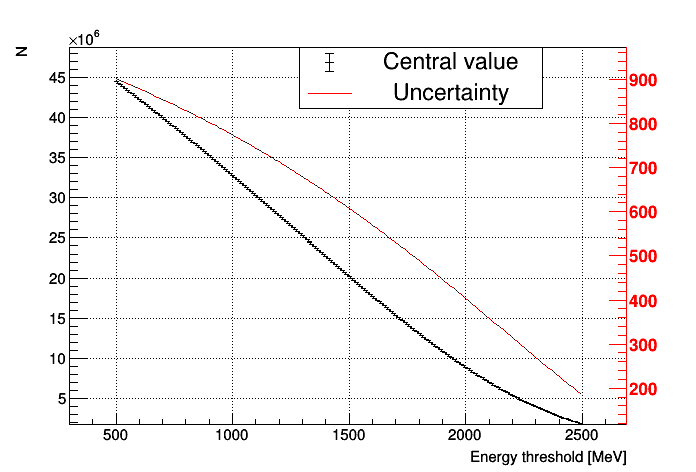

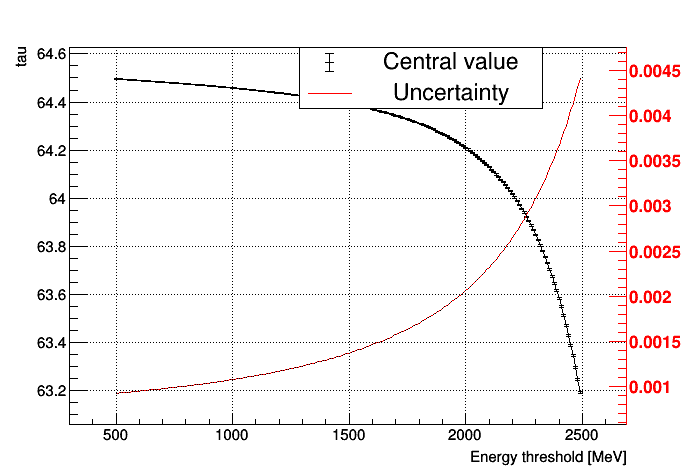

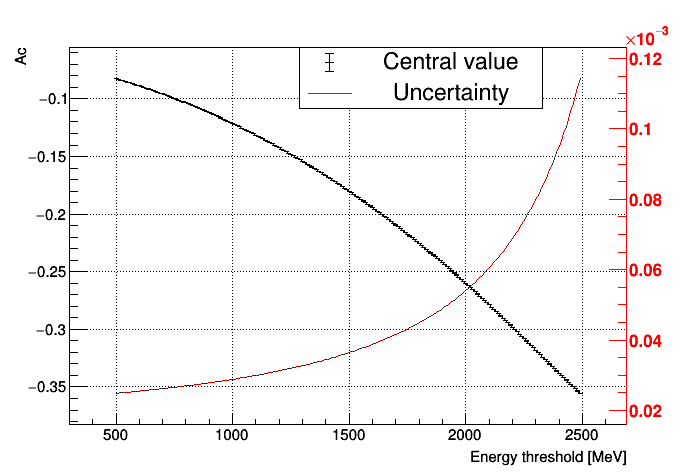

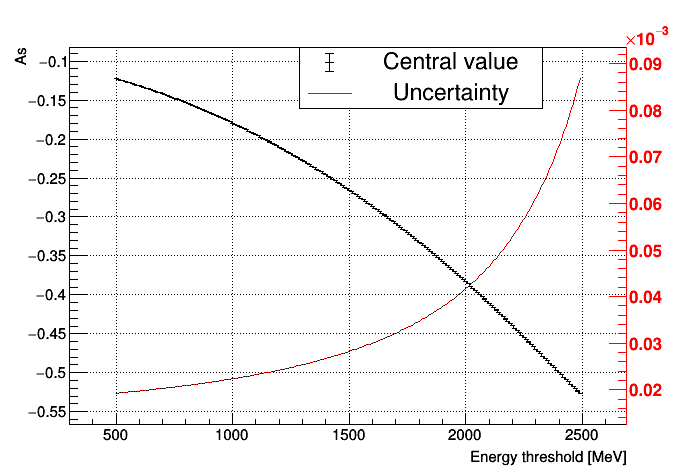

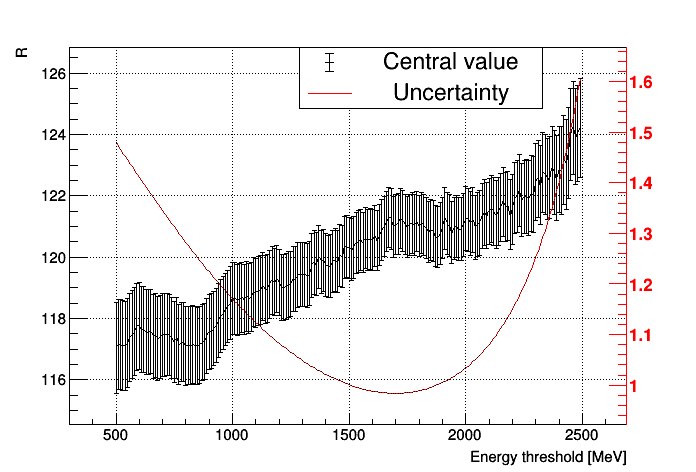

In [22]:
canvas = []
for n in range(5):
    central_graphs[n].SetTitle(';%s;%s'%('Energy threshold [MeV]',names[n]))
    c = Draw_graph_and_error(central_graphs[n],error_graphs[n])
    canvas.append(c)
    canvas[n][0].Draw()
    

In [8]:
#20 slices with equal bin numbers
#from 100 MeV to 3100 MeV
energy_bin_shift = 10
bin_limits = []
for n in range(20):
    bin_limit_low  = energy_bin_shift + n*15 + 1
    bin_limit_high = energy_bin_shift + (n+1)*15
    bin_limits.append([bin_limit_low,bin_limit_high])
# print bin_limits

In [9]:
#50 slices with equal entries
#from 100 MeV to 3100 MeV
e_dist = th2_all.ProjectionY()
Ntotal = e_dist.Integral(11,310) # from 100 to 3100 MeV
N_per_Slice = Ntotal/20.
# print N_per_Slice
bin_limits_equal = []
bin_limit_low = 11
bin = 11
while bin < 311:
    integral = e_dist.Integral(bin_limit_low,bin)
    integral_next = e_dist.Integral(bin_limit_low,bin+1)
    if bin == 310:
        if len(bin_limits_equal) == 20:
            bin_limits_equal[19][1] = bin
            bin_limits_equal[19][2] += integral
        else:
            bin_limits_equal.append([bin_limit_low,bin,integral])
        bin += 1

    elif integral<N_per_Slice and integral_next>N_per_Slice:
        if N_per_Slice - integral < integral_next - N_per_Slice:
            bin_limits_equal.append([bin_limit_low,bin,integral])
            bin += 1        
        else:
            bin_limits_equal.append([bin_limit_low,bin+1,integral_next])
            bin += 2
        bin_limit_low = bin
    else:
        bin += 1

# print bin_limits_equal
# print len(bin_limits_equal)

In [25]:
# #cos+sin fit overall
# canvas = R.TCanvas()
# wiggle = th2_all.ProjectionX()
# wiggle.Fit(cos_sin_fit,'EM','',t_start,t_end)
# wiggle.GetXaxis().SetRangeUser(t_start,200)
# R.gPad.SetLogy(1)
# wiggle.Draw()
# canvas.Draw()

In [26]:
# #phase fit overall
# R.gStyle.SetOptFit(1111)
# canvas = R.TCanvas()
# wiggle = th2_all.ProjectionX()
# PhaseFit(wiggle,phase_fit,t_start,t_end)
# wiggle.GetXaxis().SetRangeUser(t_start,200)
# wiggle.SetTitle('run 2,C; time [#mu s]; N / {0} #mu s'.format(t_bin_width))
# R.gPad.SetLogy(1)
# # wiggle.SetStats(1)
# wiggle.Draw()
# canvas.Draw()

In [27]:
# canvases = []
# hists = []
# phase_fit.SetParameters(5e+7, 66.38, 0.1, 0.1, 116.,omega_a_ref)
# for bin_limit in bin_limits:
#     canvases.append(R.TCanvas())
#     wiggle = FitScan_energySlices(bin_limit,th2_all,phase_fit)
#     wiggle.GetXaxis().SetRangeUser(50,150)
#     wiggle.Draw()
#     hists.append(wiggle)
#     canvases[-1].Draw()

In [22]:
# central_graphs = [R.TGraphErrors()]
# error_graphs = []
# canv = r.TCanvas()
# rvsE_graph = r.TGraphErrors()
# rvsE_graph.SetTitle('R versus E bin; energy bin center [MeV]; R')
# for hist, E in zip(hists, centers):
#     fit_func = hist.GetFunction('phasefit')
#     if fit_func.GetParError(4) < 1000 and abs(fit_func.GetParameter(4))<1000:
#         rvsE_graph.SetPoint(rvsE_graph.GetN(), E, fit_func.GetParameter(4))
#         rvsE_graph.SetPointError(rvsE_graph.GetN()-1, 0, fit_func.GetParError(4))
# rvsE_graph.Fit('pol0')
# rvsE_graph.Draw('ap')
# canv.Draw()
# canv.Print('rVersusEBinSuperbowl.pdf')

print e_bin_width


10.0


In [23]:
#energy slices scan
central_graphs_eslice_e = [R.TGraphErrors() for n in range(5)]
error_graphs_eslice_e = [R.TGraph() for n in range(5)]
name_temp = 'E_slices_%s_%s'
#setup graphs 
for n in range(5):
    central_graphs_eslice_e[n].SetName(name_temp%(namesPhase[n],'graph'))
    error_graphs_eslice_e[n].SetName(name_temp%(namesPhase[n],'error'))
    central_graphs_eslice_e[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
    error_graphs_eslice_e[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
#do scan
hists_eslice_e = []
phase_fit.SetParameters(5e+7, 66.38, 0.1, 0.1, 116.,omega_a_ref)
for nSlice,bin_limit in enumerate(bin_limits):
    e_bin_center = ( bin_limit[0] + bin_limit[1] - 1. )*e_bin_width/2.   
    print  e_bin_center
    wiggle = FitScan_energySlices(bin_limit,th2_all,phase_fit)    
    hists_eslice_e.append(wiggle)
    for n in range(5):
        value = phase_fit.GetParameter(n)
        error = phase_fit.GetParError(n)
        central_graphs_eslice_e[n].SetPoint(nSlice,e_bin_center,value)
        central_graphs_eslice_e[n].SetPointError(nSlice,0.,error)
        error_graphs_eslice_e[n].SetPoint(nSlice,e_bin_center,error)

175.0
325.0
475.0
625.0
775.0
925.0
1075.0
1225.0
1375.0
1525.0
1675.0
1825.0
1975.0
2125.0
2275.0
2425.0
2575.0
2725.0
2875.0
3025.0
 NEW MINIMUM FOUND.  GO BACK TO MINIMIZATION STEP.
                                                  V
                                                  V
                                                  V
                                               VVVVVVV
                                                VVVVV
                                                 VVV
                                                  V



## Eenergy slices scan
* 20 slices from 100 MeV to 3100 MeV

### Two strategy
* Equal energy width
* Equal events per slice

### Equal Energy width
* 150 MeV per slice

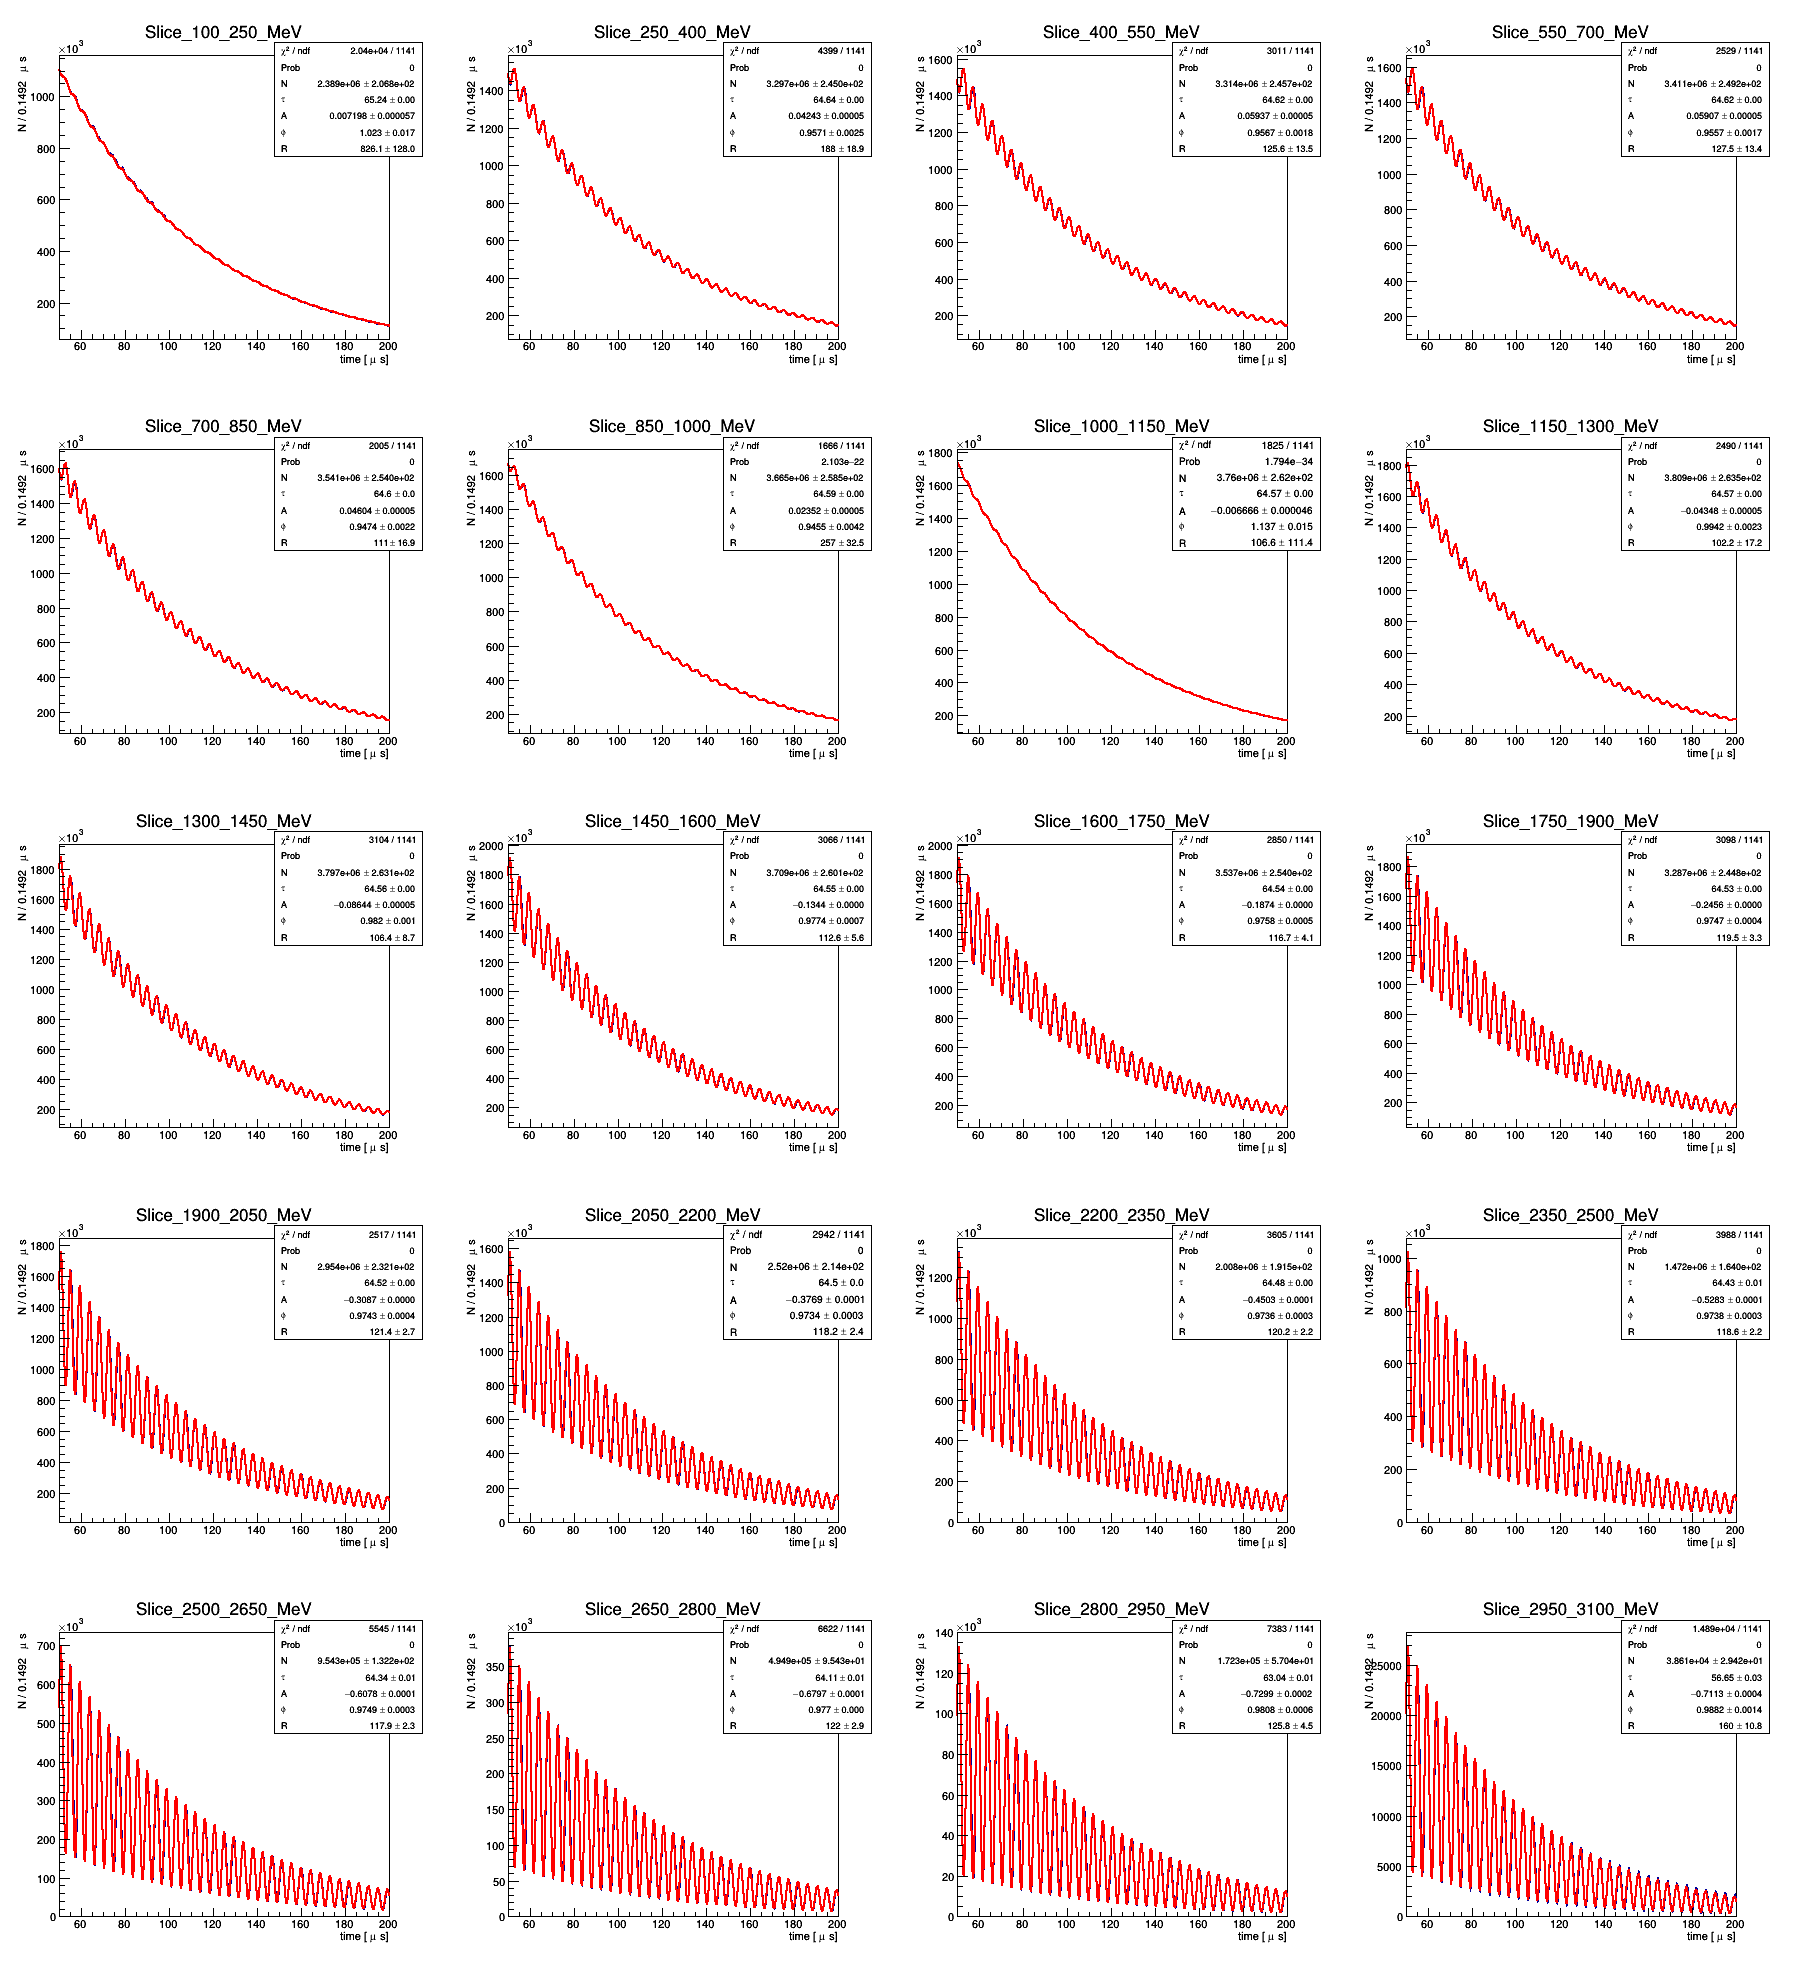

In [24]:
#draw slices wiggles
# canvases = []
# for h in hists_eslice_e:
#     canvases.append(R.TCanvas())
#     h.GetXaxis().SetRangeUser(50,200)
#     h.Draw()
#     canvases[-1].Draw()
#draw slices wiggles
canvas = R.TCanvas('e_slice_e','e_slice_e',1800,2000)
canvas.Divide(4,5)
for n,h in enumerate(hists_eslice_e):
    canvas.cd(n+1)    
    # pad = R.TPad('pad%s'%(n),'pad%s'%(n),0,0,1,1)
    # pad.Draw()
    # pad.cd()
    # pads.append(pad)
    h.GetXaxis().SetTitleOffset(1)
    h.GetYaxis().SetTitleOffset(1.6)
    
    # pad.SetLeftMargin(0.1)
    h.GetXaxis().SetRangeUser(50,200)
    h.SetStats(0)
    h.SetStats(1)
    h.Draw()
canvas.cd(0)
canvas.Draw()    


In [31]:
# #draw parameters vs slices
# canvases = []
# R.gStyle.SetOptFit(0)
# for n in range(5):    
#     canvases.append(R.TCanvas())
#     central_graphs[n].GetHistogram().SetStats(0)
#     central_graphs[n].SetTitle('{0:} versus E-slice; Energy bin center [MeV]; {0:}'.format(namesPhase[n]))
#     central_graphs[n].Fit('pol0')
#     central_graphs[n].GetFunction('pol0').SetLineColor(R.kBlue)    
#     # (central_graphs[n].GetFunction('stats')).Delete()
#     central_graphs[n].Draw('ap')
#     canvases[-1].Draw()




## Five parameters *vs* energy bin center
* second peak at N distribution: same as energy distribution
* Platform region of $\tau$ distribution, and visible decreasing central value
* Zero point of *A* distribution about 100 MeV and 1050 MeV
* Largest uncertainty of $w_{a}$ and $\phi$ in about 100 MeV and 1050 MeV


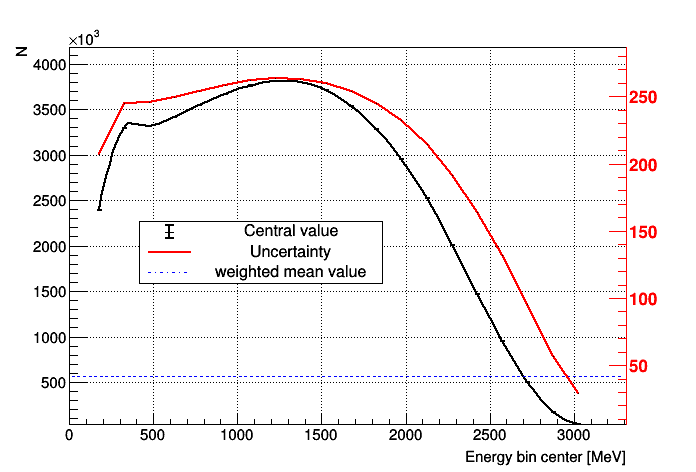

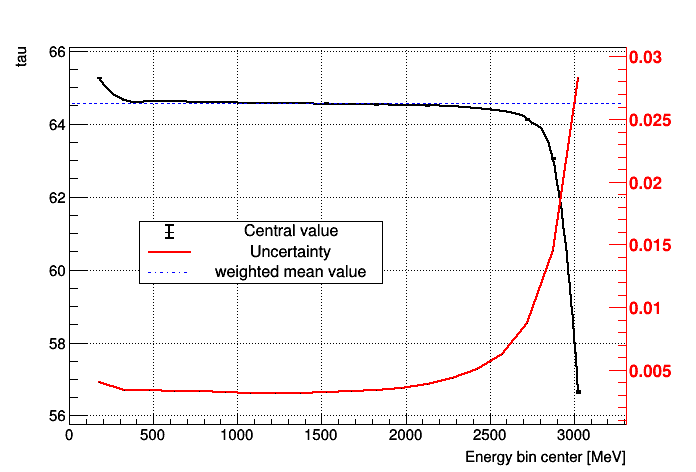

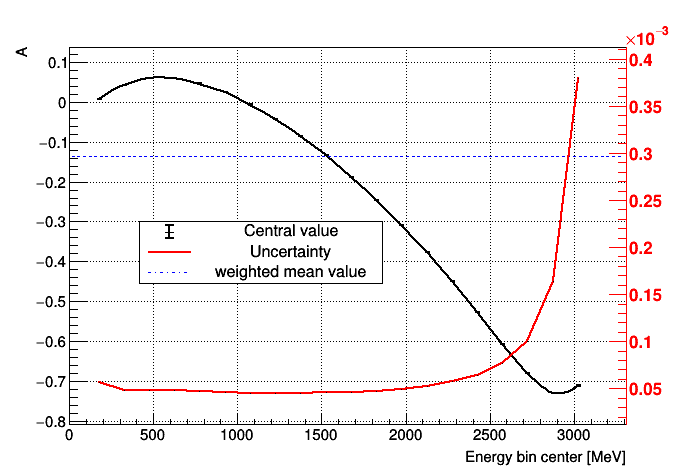

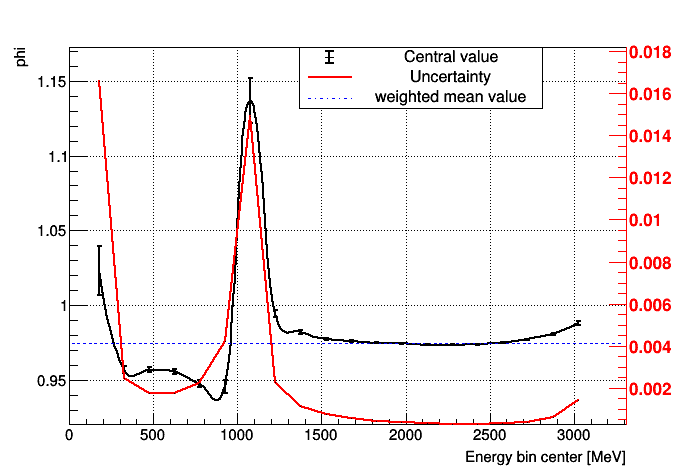

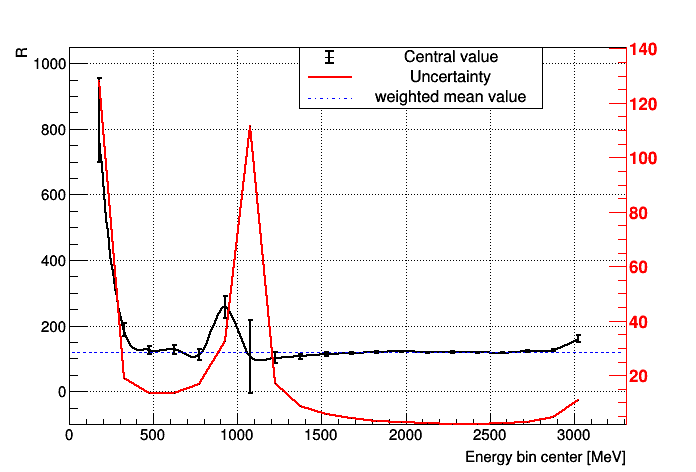

In [32]:
canvases = []
legPos = [
    [0.2,0.4],
    [0.2,0.4],
    [0.2,0.4],
    [0.43,0.77],
    [0.43,0.77]
]
for n in range(5):    
    c = Draw_graph_and_error(central_graphs_eslice_e[n],error_graphs_eslice_e[n],True,legPos[n])
    canvases.append(c)
    c[0].Draw()


In [33]:
#energy slices scan with equal stats
R.gStyle.SetOptFit(1111)
R.gStyle.SetOptStat(0)
central_graphs_eslice_n = [R.TGraphErrors() for n in range(5)]
error_graphs_eslice_n = [R.TGraph() for n in range(5)]
name_temp = 'E_slices_%s_%s'
#setup graphs 
for n in range(5):
    central_graphs_eslice_n[n].SetName(name_temp%(namesPhase[n],'graph'))
    error_graphs_eslice_n[n].SetName(name_temp%(namesPhase[n],'error'))
    central_graphs_eslice_n[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
    error_graphs_eslice_n[n].SetTitle(';%s;%s'%('Energy bin center [MeV]',namesPhase[n]))
#do scan
hists_eslice_n = []
phase_fit.SetParameters(5e+7, 66.38, 0.1, 0.1, 116.,omega_a_ref)
for nSlice,bin_limit in enumerate(bin_limits_equal):
    e_bin_center = ( bin_limit[0] + bin_limit[1] - 1. )*e_bin_width/2.    
    wiggle = FitScan_energySlices(bin_limit,th2_all,phase_fit)
    hists_eslice_n.append(wiggle)
    for n in range(5):
        value = phase_fit.GetParameter(n)
        error = phase_fit.GetParError(n)
        central_graphs_eslice_n[n].SetPoint(nSlice,e_bin_center,value)
        central_graphs_eslice_n[n].SetPointError(nSlice,0.,error)
        error_graphs_eslice_n[n].SetPoint(nSlice,e_bin_center,error)

## Energy slice scan with equal events per slice

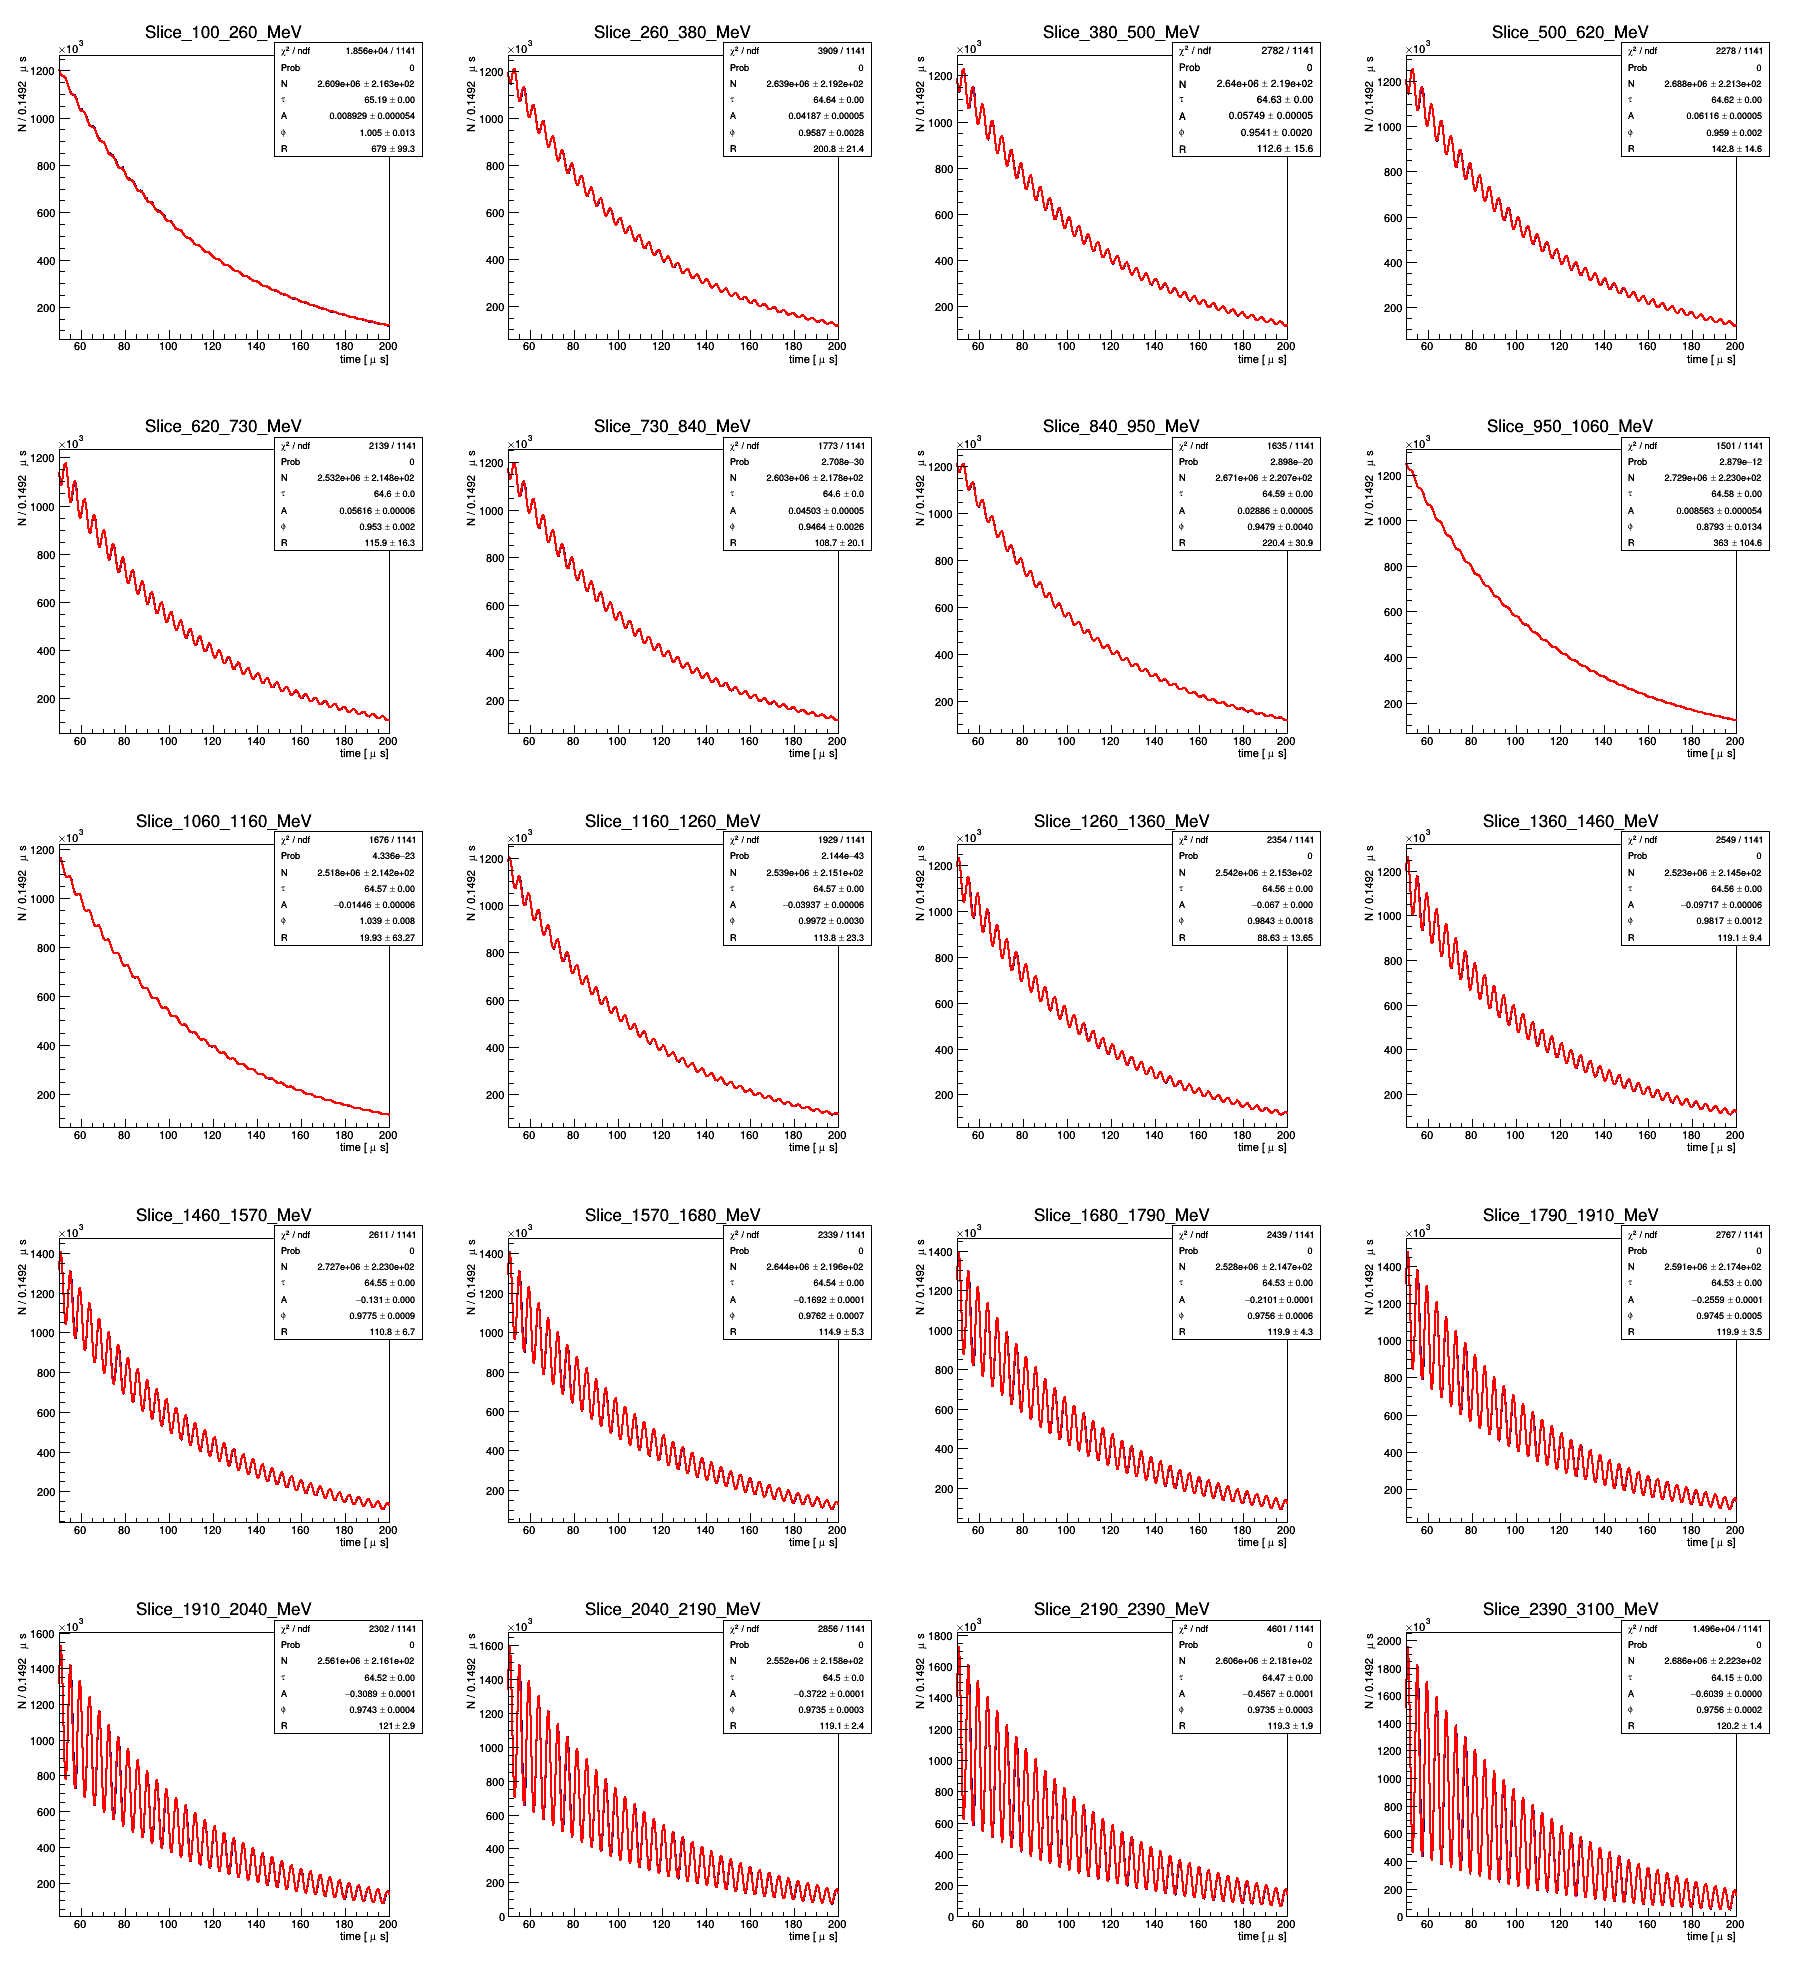

In [34]:
#draw slices wiggles
canvas = R.TCanvas('e_slice_n','e_slice_n',1800,2000)
pads = []
canvas.Divide(4,5)
for n,h in enumerate(hists_eslice_n):
    canvas.cd(n+1)    
    # pad = R.TPad('pad%s'%(n),'pad%s'%(n),0,0,1,1)
    # pad.Draw()
    # pad.cd()
    # pads.append(pad)
    h.GetXaxis().SetTitleOffset(1)
    h.GetYaxis().SetTitleOffset(1.6)
    
    # pad.SetLeftMargin(0.1)
    h.GetXaxis().SetRangeUser(50,200)
    h.SetStats(0)
    h.SetStats(1)
    h.Draw()
canvas.cd(0)
canvas.Draw()


## Five parameters *vs* energy bin center
* decreasing $\tau$ 
* Zero points of *A*


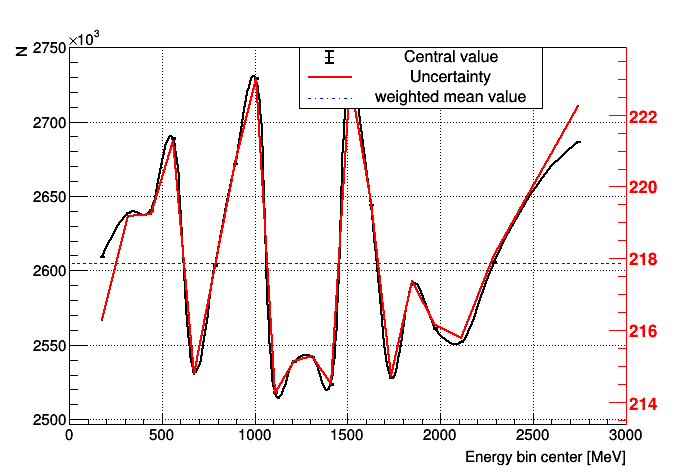

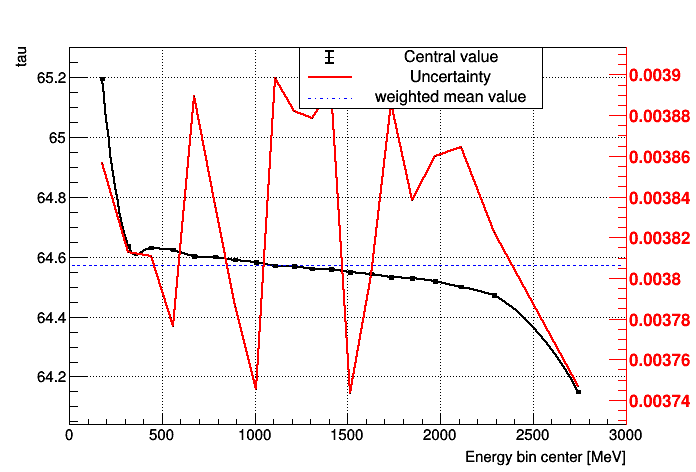

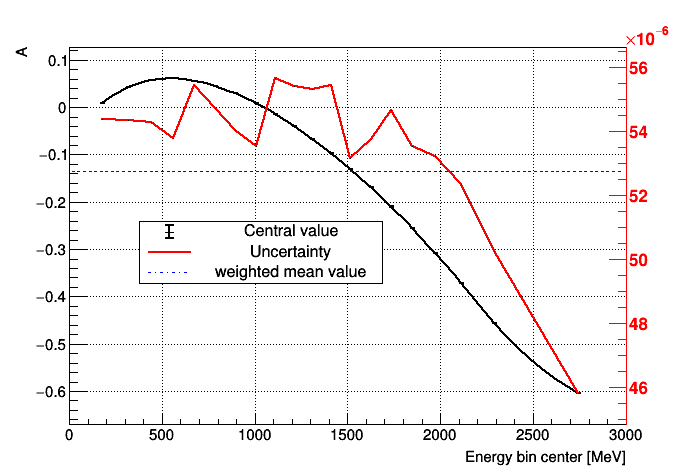

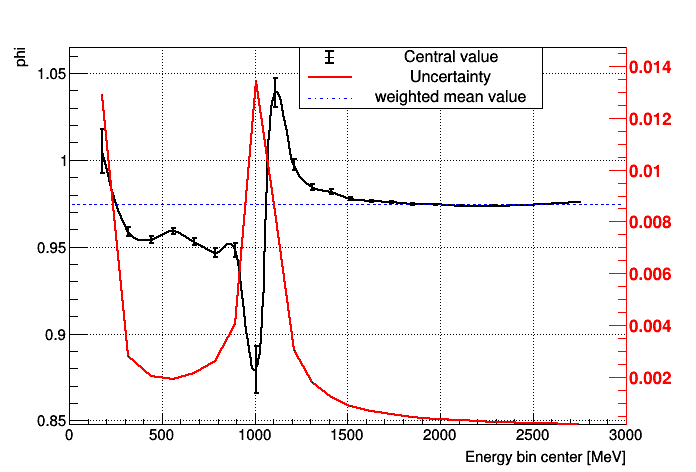

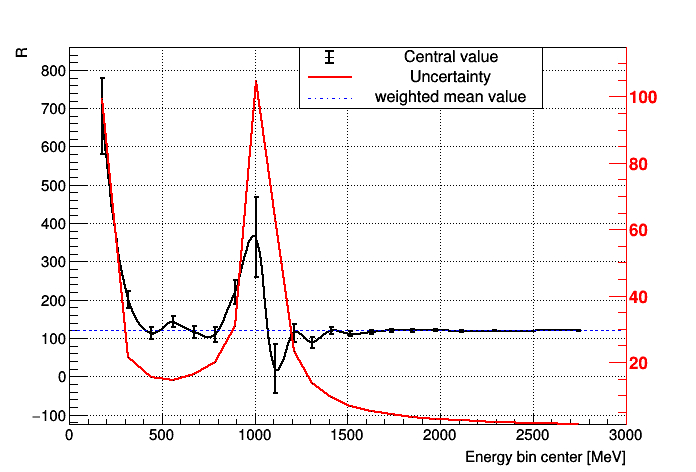

In [35]:
canvases = []
# 0.43, 0.77, 0.78, 0.90
legPos = [
    [0.43,0.77],
    [0.43,0.77],
    [0.2,0.4],
    [0.43,0.77],
    [0.43,0.77]
]
for n in range(5):    
    c = Draw_graph_and_error(central_graphs_eslice_n[n],error_graphs_eslice_n[n],True,legPos[n])
    canvases.append(c)
    c[0].Draw()


In [36]:
#calo by calo fitting
#threshold cut applied
R.gStyle.SetOptFit(1111)
central_graphs_calos = [R.TGraphErrors() for n in range(5)]
error_graphs_calos = [R.TGraph() for n in range(5)]
name_temp = 'Calos_%s_%s'
#setup graphs 
for n in range(5):
    central_graphs_calos[n].SetName(name_temp%(namesPhase[n],'graph'))
    error_graphs[n].SetName(name_temp%(namesPhase[n],'error'))
    central_graphs_calos[n].SetTitle(';%s;%s'%('Calorimeter number',namesPhase[n]))
    error_graphs_calos[n].SetTitle(';%s;%s'%('Calorimeter number',namesPhase[n]))
#do scan
hists_calos = []
phase_fit.SetParameters(5e+6, 66.38, 0.1, 0.1, 116.,omega_a_ref)
t_method_bin = th2_all.GetYaxis().FindBin(e_thresh)
NbinsY = th2_all.GetNbinsY()
for nCalo in range(24):
    th2 = th2_calos[nCalo]    
    wiggle = th2.ProjectionX('%s'%(nCalo),t_method_bin,NbinsY)
    wiggle.SetTitle('calorimeter: {0:}; time [#mu s]; N / {1} #mu s'.format(nCalo, t_bin_width))
    PhaseFit(wiggle,phase_fit,t_start,t_end)
    hists_calos.append(wiggle)
    for n in range(5):
        value = phase_fit.GetParameter(n)
        error = phase_fit.GetParError(n)
        central_graphs_calos[n].SetPoint(nCalo,nCalo,value)
        central_graphs_calos[n].SetPointError(nCalo,0.,error)
        error_graphs_calos[n].SetPoint(nCalo,nCalo,error)

# Scan of 24 calorimeters

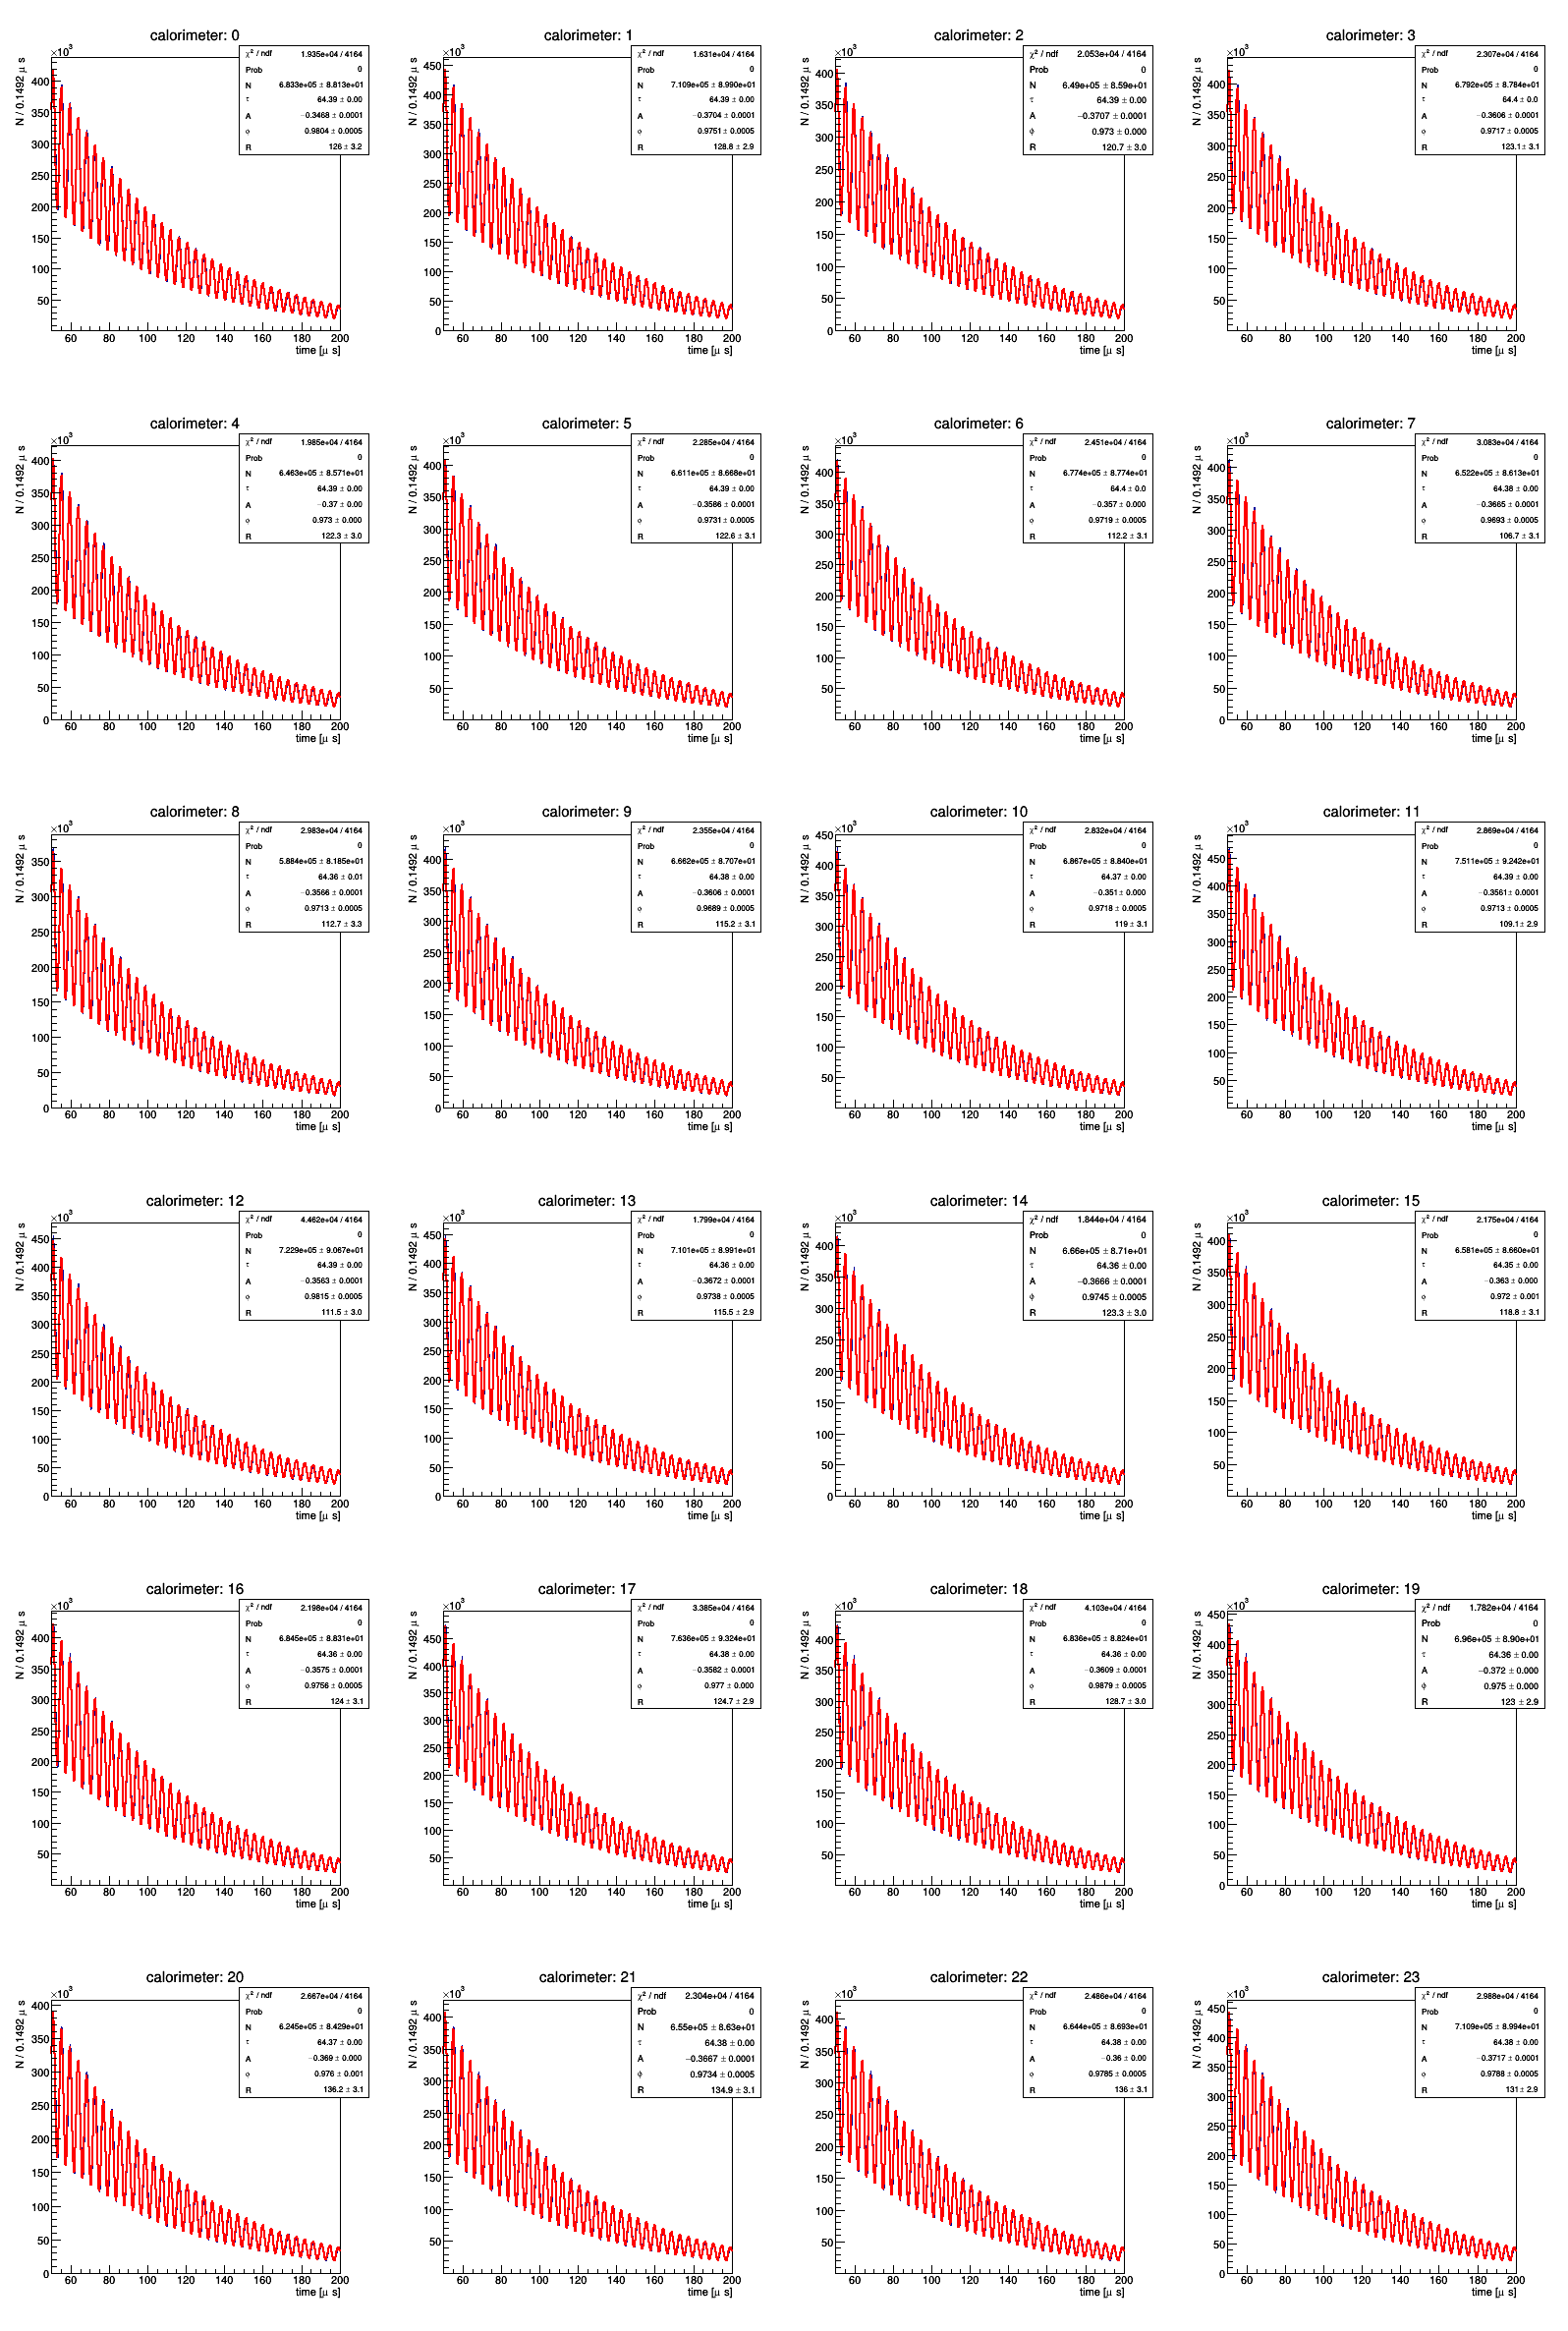

In [37]:
#draw calo wiggles
canvas = R.TCanvas('calo_wiggles','calo_wiggles',1600,2400)
canvas.Divide(4,6)
for n,h in enumerate(hists_calos):
    canvas.cd(n+1)
    h.GetXaxis().SetRangeUser(50,200)
    h.SetStats(0)
    h.SetStats(1)
    h.GetYaxis().SetTitleOffset(1.5)
    h.Draw()
canvas.cd(0)
canvas.Draw()


## Five parameters measurement *vs* calorimeter number
* 9th-calorimeter has lowest statistics and highest uncertainties

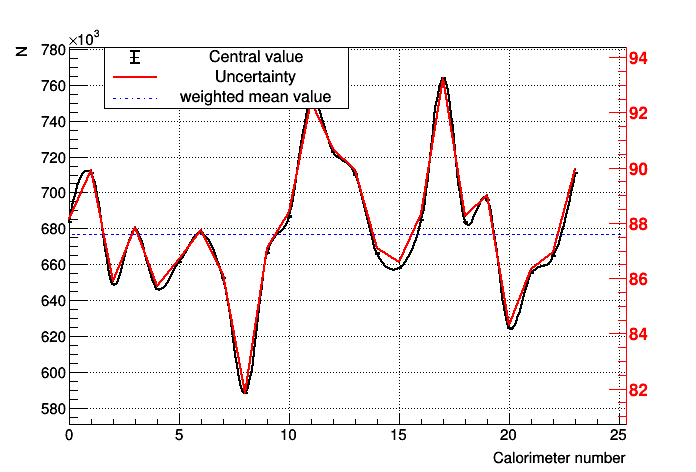

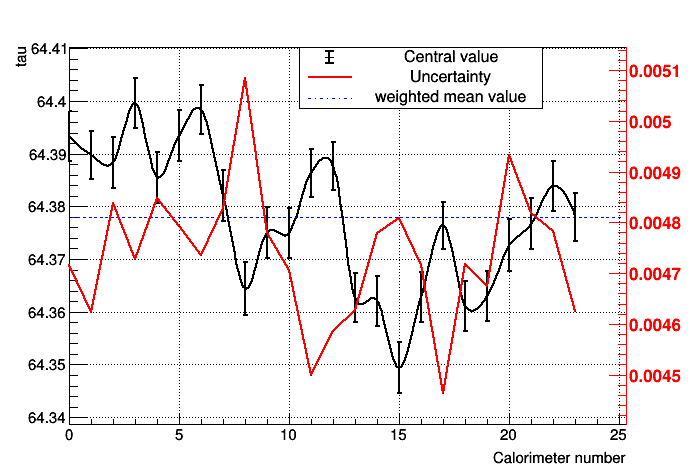

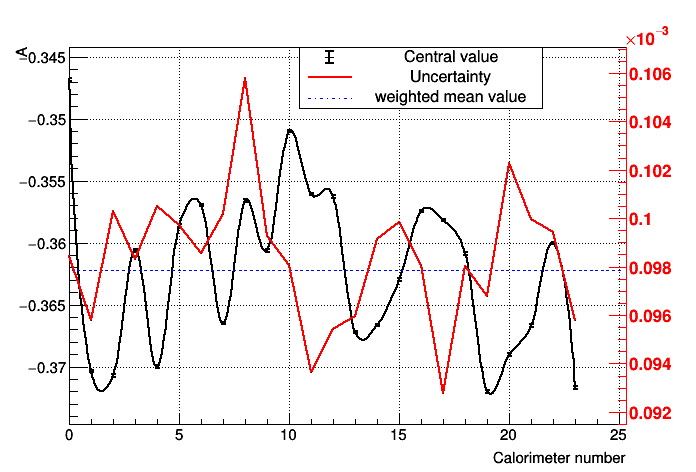

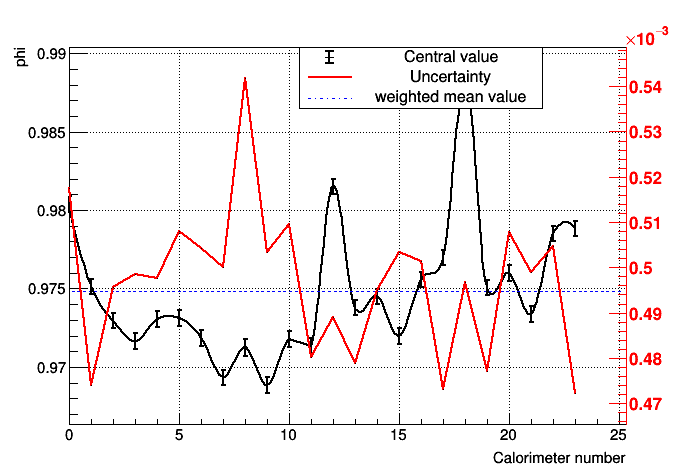

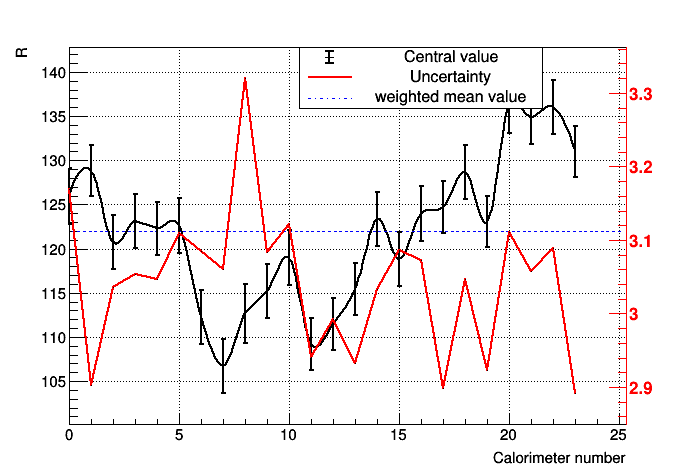

In [38]:
#draw parameters by calorimeters
canvases = []
legPos = [
    [0.15,0.77],
    [0.43,0.77],
    [0.43,0.77],
    [0.43,0.77],
    [0.43,0.77]
]
for n in range(5):
    c = Draw_graph_and_error(central_graphs_calos[n],error_graphs_calos[n],True,legPos[n])
    canvases.append(c)
    c[0].Draw()

In [39]:
#analysis residuals
residuals = []
for ncalo,hist in enumerate(hists_calos):
    residual = hist.Clone()
    residual.GetXaxis().SetRangeUser(t_start,300)
    residual.SetName('residual_calo_{0:}'.format(nCalo))    
    for nBin in range(1,residual.GetNbinsX()+1):
        bin_center = residual.GetXaxis().GetBinCenter(nBin)
        fit_val = hist.GetFunction('phasefit').Eval(bin_center)
        bin_content = hist.GetBinContent(nBin)
        residual.SetBinContent(nBin,bin_content - fit_val)
    residuals.append(residual)

## Residual analysis

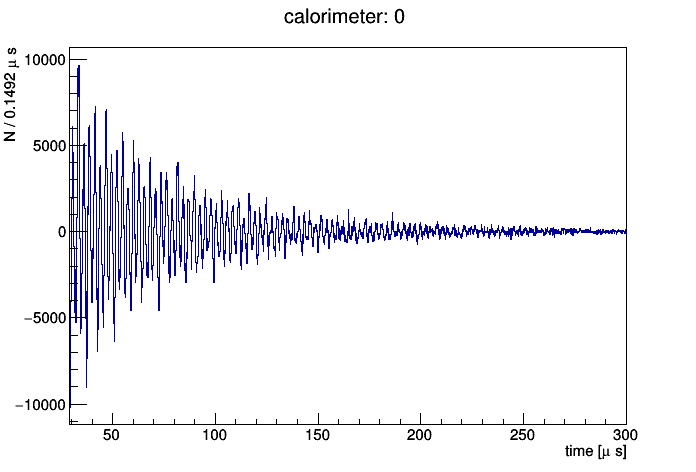

In [40]:
#draw residual calo 0
canvas = R.TCanvas()
residuals[0].Draw('HIST')
canvas.Draw()

### FFT 
* Residuals
* Without threshold cut
* With threshold cut

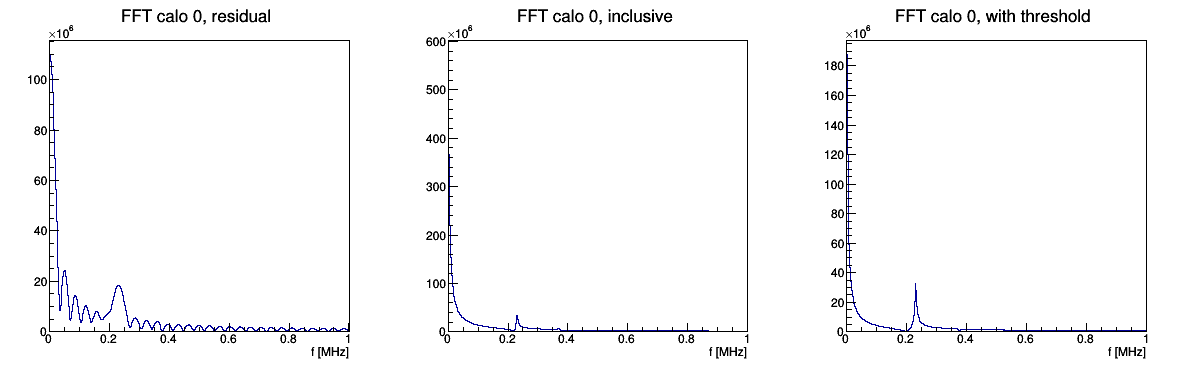

In [41]:
#FFT for calo 0: residual, threshold on, threshold off
NbinsX = hists_calos[0].GetNbinsX()
nCalo = 0
fft_hist = R.TH1F('FFT{0:}'.format(nCalo),'FFT calo {0:};f [MHz]'.format(nCalo),NbinsX,0,1./t_bin_width)
#residual
fft_residual = fft_hist.Clone()
fft_residual.SetName('FFT calo {0:}, residual '.format(nCalo))
fft_residual.SetTitle('FFT calo {0:}, residual '.format(nCalo))
residual.FFT(fft_residual,'MAG')
#threshold off
fft_thres_off = fft_hist.Clone()
fft_thres_off.SetName('FFT calo {0:}, thres off '.format(nCalo))
fft_thres_off.SetTitle('FFT calo {0:}, inclusive '.format(nCalo))
th2_calos[nCalo].ProjectionX().FFT(fft_thres_off,'MAG')
#threshold on
fft_thres_on = fft_hist.Clone()
fft_thres_on.SetName('FFT calo {0:}, thres on '.format(nCalo))
fft_thres_on.SetTitle('FFT calo {0:}, with threshold '.format(nCalo))
hists_calos[nCalo].FFT(fft_thres_on,'MAG')
canvas = R.TCanvas('FFT{0:}'.format(nCalo),'FFT{0:}'.format(nCalo),1200,400)

canvas.Divide(3)
canvas.cd(1)
fft_residual.GetXaxis().SetRangeUser(0,1)
fft_residual.Draw()

canvas.cd(2)
fft_thres_off.GetXaxis().SetRangeUser(0,1)
fft_thres_off.Draw()

canvas.cd(3)
fft_thres_on.GetXaxis().SetRangeUser(0,1)
fft_thres_on.Draw()

canvas.cd(0)
canvas.Draw()

In [42]:
def endpoint_line(x, p):
    return p[0]*x[0] - p[0]*p[1]

def FindPoint(hist,ratio):
    cumulative = hist.GetCumulative()
    maximum = cumulative.GetMaximum()
    return cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(maximum*ratio))

def FindPointFast(cumulative,maximum,ratio):
    return cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(maximum*ratio))

fit_func = R.TF1('fit_func', endpoint_line, 0, 3200, 2)
fit_func.SetParNames('slope', 'endpoint [MeV]')
fit_func.SetLineColor(R.kRed)

In file included from input_line_266:1:
In file included from /Applications/root_v6.24.00/include/CPyCppyy/API.h:30:
In file included from /usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/Python.h:88:
/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/unicodeobject.h:534:5: warning: 'register' storage class specifier is deprecated and incompatible with C++17 [-Wdeprecated-register]
    register PyObject *obj,     /* Object */
    ^~~~~~~~~
/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/unicodeobject.h:553:5: warning: 'register' storage class specifier is deprecated and incompatible with C++17 [-Wdeprecated-register]
    register PyObject *obj      /* Object */
    ^~~~~~~~~
/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/include/python2.7/unicodeobject.h:575:5: warning: 'register' storage class specifier is deprecated and incompa

In [43]:
def FitEndPoint(hist,fitModel,start,end):
    cumulative = hist.GetCumulative()
    cumulative_max = cumulative.GetMaximum()
    start_fit = cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(cumulative_max*start))
    end_fit = cumulative.GetBinLowEdge(cumulative.FindFirstBinAbove(cumulative_max*end)+1)
    hist.Fit(fitModel, 'EQM','',start_fit, end_fit)
    endpoint_val = fitModel.GetParameter(1)
    endpoint_err = fitModel.GetParError(1)
    slope_val = fitModel.GetParameter(0)
    slope_err = fitModel.GetParError(0)    
    chi2_ndf = fit_func.GetChisquare()/fit_func.GetNDF()
    return [slope_val,slope_err,endpoint_val,endpoint_err,chi2_ndf]

In [44]:
#found the fitting region
energy_dist_all = th2_all.ProjectionY()
cumulative = energy_dist_all.GetCumulative()
maximum = cumulative.GetMaximum()
start = 0.85
chi2 = []
for n in range(100):
    start = 0.85 + n*0.001
    M = (0.95 - start)/0.001
    chi2.append([])
    for m in range(int(M)):        
        fit_func.SetParameters(-6.e4,3000.)
        end = start + 0.05 + m * 0.001 
        start_fit = FindPointFast(cumulative,maximum,start)
        end_fit = FindPointFast(cumulative,maximum,end)
        energy_dist_all.Fit(fit_func, 'EQM','',start_fit, end_fit)
        c2 = fit_func.GetChisquare()
        ndf = fit_func.GetNDF()
        p0 = fit_func.GetParameter(0)
        p1 = fit_func.GetParameter(1)
        chi2[-1].append([p0,p1,c2,ndf])

## Endpoint fit
* Linear approximation at the tail of energy distribution
* Linear fit and extrapolate to get the endpoint
* Most linear like regions are found through a scan of start and end positions

100
99


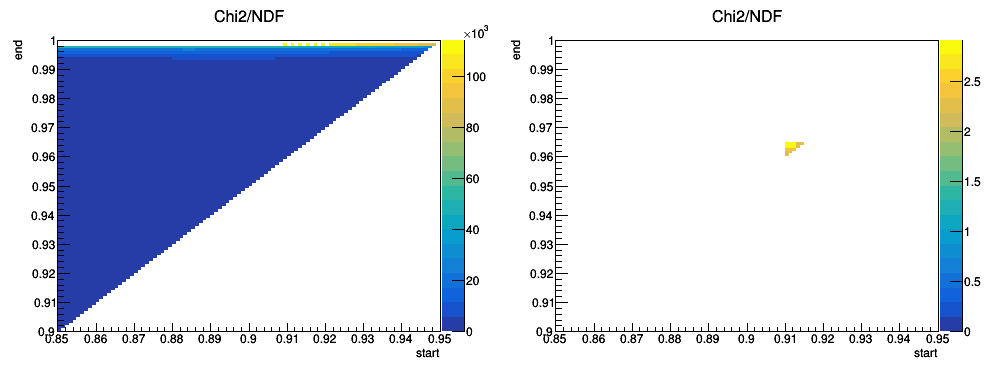

In [45]:
th2_chi2_ndf = R.TH2D('chi2/ndf',';start;end',100,0.85,0.95,100,0.9,1.0)
th2_chi2_ndf.SetTitle('Chi2/NDF;start;end')
th2_chi2_ndf_filter = th2_chi2_ndf.Clone()
print len(chi2)
print len(chi2[0])
for n in range(100):
    start = 0.85 + n*0.001
    M = (0.95 - start)/0.001    
    for m in range(int(M)):
        end = start + 0.05 + m * 0.001        
        c2 = chi2[n][m][2]/chi2[n][m][3]
        th2_chi2_ndf.SetBinContent(n,n+m,c2)
        if c2 < 3:
            th2_chi2_ndf_filter.SetBinContent(n,n+m,c2)
        if c2 < 2:
            print n,n+m,c2
canvas = R.TCanvas('endpointFitOpt','endpointFitOpt',1000,400)
R.gStyle.SetOptStat(0)
canvas.Divide(2)
canvas.cd(1)
th2_chi2_ndf.Draw('COLZ')
th2_chi2_ndf.GetYaxis().SetTitleOffset(1.5)
canvas.cd(2)
th2_chi2_ndf_filter.Draw('COLZ')
th2_chi2_ndf_filter.GetYaxis().SetTitleOffset(1.5)
canvas.cd(0)
canvas.Draw()

In [46]:
#fit endpoints of calos
fit_res = []
hists_endpoint = []
start = 0.913
end = 0.963
for nCalo,th2_calo in enumerate(th2_calos):
    fit_func.SetParameters(-3.5e3,3000)
    hists_endpoint.append(th2_calo.ProjectionY())
    res = FitEndPoint(hists_endpoint[-1],fit_func,start,end)
    fit_res.append(res)
#fit endpoint overall
fit_func.SetParameters(-6.e4,3000.)
hist_endpoint = th2_all.ProjectionY()
fit_res_all = FitEndPoint(hist_endpoint,fit_func,start,end)


2834.7789148 yes
c_double(2230.0) c_double(2470.0)
2


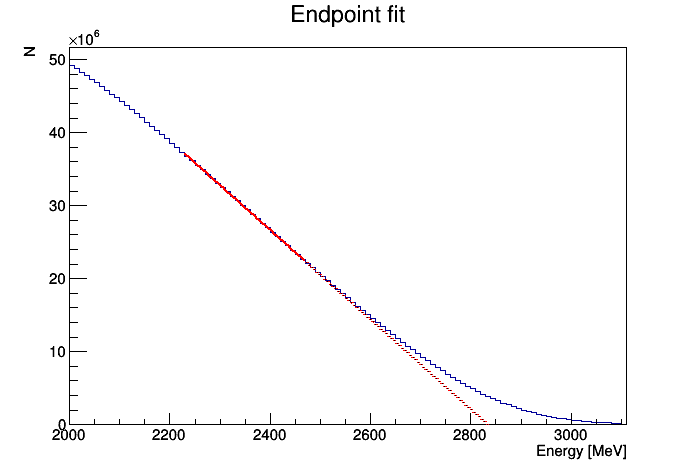

In [47]:
R.gStyle.SetOptFit(111)
R.gStyle.SetOptStat(0)
grapherr_endpoints = R.TGraphErrors()
graph_chi2_endpoints = R.TGraph()
hist_endpoint.GetXaxis().SetRangeUser(2000,3200)
hist_endpoint.GetFunction('fit_func').SetLineColor(R.kRed)
# hist_endpoint.GetFunction('fit_func').SetLineStyle(1)
func_extra = fit_func.Clone()
start_fit = ctypes.c_double(0.)
end_fit = ctypes.c_double(0.)
hist_endpoint.GetFunction('fit_func').GetRange(start_fit,end_fit)


func_extra.SetParameters(fit_res_all[0],fit_res_all[2])
print fit_res_all[2],'yes'
func_extra.SetRange(end_fit,3000)
print start_fit,end_fit
func_extra.SetLineWidth(1)
func_extra.SetLineStyle(2)
canvas = R.TCanvas()
hist_endpoint.SetTitle('Endpoint fit;Energy [MeV];N')
hist_endpoint.Draw()
func_extra.Draw('esame')
canvas.Draw()
print hist_endpoint.GetFunction('fit_func').GetLineWidth()

In [48]:
# print fit_res_all
# print fit_res
graph_err_endpoint = R.TGraphErrors()
graph_chi2_endpoint = R.TGraph()
graph_err_endpoint.SetTitle('Endpoints;Calorimeter number;Extrapolated endpoint [MeV]')
for nCalo,fit_res_calo in enumerate(fit_res):
    graph_err_endpoint.SetPoint(nCalo,nCalo,fit_res_calo[2])
    graph_err_endpoint.SetPointError(nCalo,0.,fit_res_calo[3])
    graph_chi2_endpoint.SetPoint(nCalo,nCalo,fit_res_calo[4])

## Scan of endpoints *vs* calorimeter number

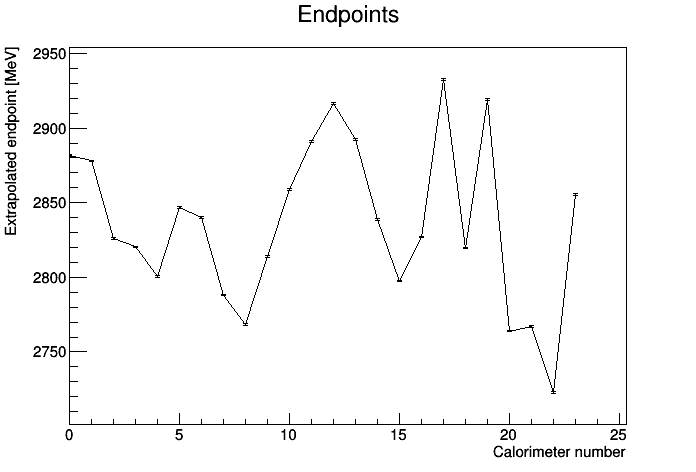

In [49]:
#draw parameters by calorimeters
c = R.TCanvas()

graph_err_endpoint.Draw('alp')

c.Draw()

In [13]:
# The w = 1.43940, T = 2*Pi/w = 4.365
# phase = 2*Pi*(t%T)/T
# phase bin width = 2*Pi*DeltaT/T = 2*Pi*0.1492/4.365
# bin number = 4.365/0.1492 = 29.25
# the phase map x range from 0 to 30 * binWidth
class PhaseMapper:
    def __init__(self,oldTH2):
        self.NX = oldTH2.GetNbinsX()
        self.NY = oldTH2.GetNbinsY()
        self.stepX = oldTH2.GetXaxis().GetBinWidth(1)
        self.stepY = oldTH2.GetYaxis().GetBinWidth(1)
        self.oldTH2 = oldTH2

        self.Pi = 3.141592653
        self.T = 4.365

    def GetNewH(self):
        newStepX = 2*self.Pi*0.1492/self.T
        self.newXmax = 30*newStepX
        h = R.TH2D('PhaseE','Phase map: phase vs energy',
                   30,0.,self.newXmax,
                   self.NY,0,self.NY*self.stepY)
        return h

    def ReMap(self):
        newTH2 = self.GetNewH()
        T = 4.365
        w = omega_a_ref*(113.4e-6+1)
        phi = 0.9791
        integral = 0.
        for nx in range(self.NX):
            x_old = (nx+0.5)*self.stepX
            x_new = (w*x_old + phi)%(2*self.Pi)
            # print x_old,x_new
            for ny in range(self.NY):
                value = self.oldTH2.GetBinContent(nx+1,ny+1)
                if value == 0.:
                    continue               
                integral += value
                
                
                
                nx_new = newTH2.GetXaxis().FindBin(x_new)
                newTH2.Fill(x_new,(ny+0.5)*self.stepY,value)
#                 newTH2.SetBinContent(nx_new,ny+1,value_new)
        print integral
        print self.oldTH2.Integral()
        print newTH2.Integral()
        
        return newTH2
    

    
    

In [14]:
th2_remap = PhaseMapper(th2_all).ReMap()


14410021700.0
13387915475.0
14410021700.0


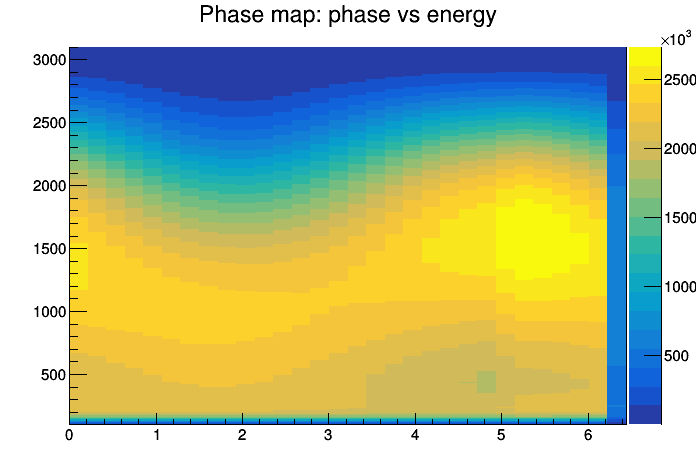

In [15]:
c = R.TCanvas()
th2_remap.GetYaxis().SetRangeUser(100,3100)
th2_remap.Draw('COLZ')
c.Draw()

Info in <TH2D::Rebin>: Rebinning only the x-axis. Use Rebin2D for rebinning both axes


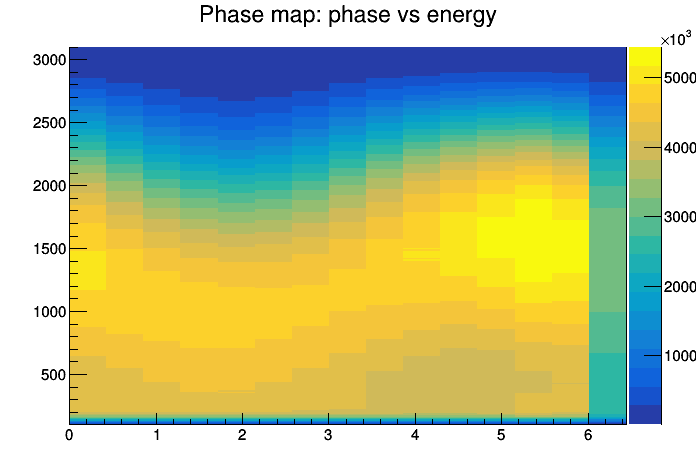

In [16]:
th2_rebin = th2_remap.Clone()
th2_rebin.Rebin(2)
c = R.TCanvas()
th2_rebin.GetYaxis().SetRangeUser(100,3100)
th2_rebin.Draw('COLZ')
c.Draw()


In [17]:
th2_rebin.GetNbinsX()
th1_slices = []
for n in range(5,10):
    th1 = th2_rebin.ProjectionY('Slice%s'%(n),n,n)
    th1_slices.append(th1)
    

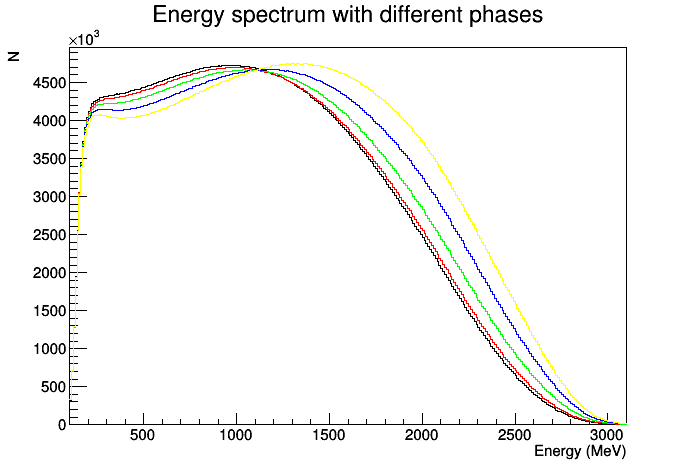

In [18]:
c = R.TCanvas()
colors = [1,2,3,4,5,6]
for n in range(5):
    th1_slices[n].SetLineColor(colors[n])
    th1_slices[n].Draw('histsame')
    th1_slices[n].SetTitle('Energy spectrum with different phases;Energy (MeV);N ')
    th1_slices[n].SetStats(0)
c.Draw()


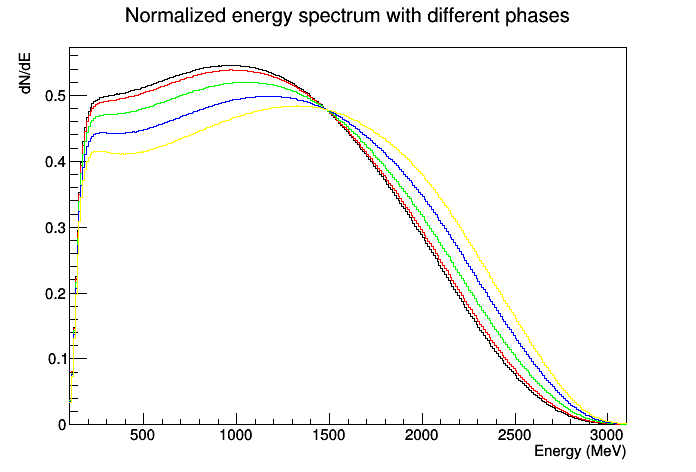

In [19]:
c = R.TCanvas()
colors = [1,2,3,4,5,6]
for n in range(5):
    th1_slices[n].Scale(100./th1_slices[n].Integral())
    th1_slices[n].SetLineColor(colors[n])
    th1_slices[n].SetTitle('Normalized energy spectrum with different phases;Energy (MeV);dN/dE ')
    th1_slices[n].Draw('histsame')
    th1_slices[n].SetStats(0)
c.Draw()


In [20]:
px = th2_remap.ProjectionX()


462403670.0
517324532.0


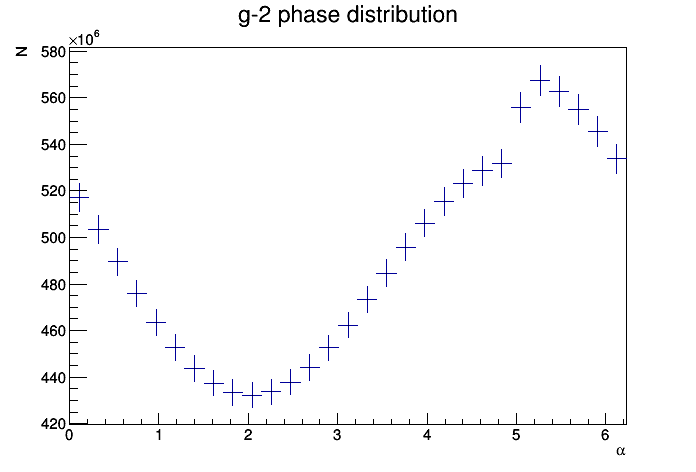

In [38]:
c = R.TCanvas()
px_new = px.Clone()
# px_new.Rebin()
px_new.Draw()
print px_new.GetBinContent(px_new.GetXaxis().FindBin(3.14))
print px_new.GetBinContent(px_new.GetXaxis().FindBin(0))
px_new.GetXaxis().SetRangeUser(0,6.2)
px_new.SetTitle('g-2 phase distribution;#alpha;N')
c.Draw()
# for n in range(px_new.GetNbinsX()):
#     print px_new.GetBinContent(n+1)